In [1]:
# import packages & variables
import argparse
import torch
import torch.nn as nn
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoModel, AutoModelForSequenceClassification
import json
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "5"

# Parameters
model_name = 'meta-llama/Meta-Llama-3.1-8B'
non_infringement_file = '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/test_division/extra_30.non_infringement.json'
infringement_file = '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/test_division/extra_30.infringement.json'
checkpoint_file = '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/models/train_input_reference_0_layer.pth'


/home/guangwei/miniconda3/envs/zdh/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Define CustumMLP for internal states train
class CustomMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(CustomMLP, self).__init__()
        self.down = nn.Linear(input_dim, hidden_dim)
        self.gate = nn.Linear(input_dim, hidden_dim)
        self.up = nn.Linear(hidden_dim, 1)
        self.activation = nn.SiLU()

    def forward(self, x):
        down_output = self.down(x)
        gate_output = self.gate(x)
        gated_output = down_output * self.activation(gate_output)
        return self.up(gated_output)

In [3]:
# Extract hidden states/reference embeddings
def extract_hidden_states(texts, model, tokenizer, batch_size=4):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model = nn.DataParallel(model)
    hidden_states = []
    
    for i in tqdm(range(0, len(texts), batch_size), desc="Processing data batches"):
        batch_texts = texts[i:i + batch_size]
        inputs = tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True).to(device)
        
        with torch.no_grad():
            outputs = model(**inputs)
        hidden_states.append(outputs.hidden_states[3].mean(dim=1).cpu().numpy())
    
    return np.vstack(hidden_states)


def extract_reference_embeddings(references, model, tokenizer, batch_size=4):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model = nn.DataParallel(model)
    embeddings = []
    for i in tqdm(range(0, len(references), batch_size), desc="Processing references"):
        batch_references = references[i:i + batch_size]
        inputs = tokenizer(batch_references, return_tensors="pt", padding=True, truncation=True).to(device)
        with torch.no_grad():
            outputs = model(**inputs)
        embeddings.append(outputs.pooler_output.cpu().numpy())
    return np.vstack(embeddings)

In [4]:
# load data for infringement & non infringement
def load_data(non_infringement_file, infringement_file):
    with open(non_infringement_file, 'r', encoding='utf-8') as file:
        non_infringement_json_data = json.load(file)

    non_infringement_outputs = [entry['input'] for entry in non_infringement_json_data]
    non_infringement_references = [entry['reference'] for entry in non_infringement_json_data]
    y_non_infringement = [1] * len(non_infringement_outputs)

    with open(infringement_file, 'r', encoding='utf-8') as file:
        infringement_json_data = json.load(file)

    infringement_outputs = [entry['input'] for entry in infringement_json_data]
    infringement_references = [entry['reference'] for entry in infringement_json_data]
    y_infringement = [0] * len(infringement_outputs)

    return non_infringement_outputs, non_infringement_references, y_non_infringement, infringement_outputs, infringement_references, y_infringement

In [5]:
from sklearn.metrics import accuracy_score, classification_report, f1_score

# Train for best model
def train_model(X_train, y_train, X_test, y_test, input_dim, hidden_dim, epochs=2000, lr=0.001, checkpoint_path=checkpoint_file):
    custom_mlp = CustomMLP(input_dim, hidden_dim)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(custom_mlp.parameters(), lr=lr)

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)

    best_accuracy = -float('inf')
    best_f1 = -float('inf')  # Track best F1-score
    best_model_state = None
    best_epoch = 0
    losses = []

    for epoch in tqdm(range(epochs), desc="Training Epochs"):
        custom_mlp.train()
        optimizer.zero_grad()
        outputs = custom_mlp(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

        # Every 10 epochs, evaluate the model
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item():.4f}")
            
            custom_mlp.eval()
            X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
            with torch.no_grad():
                y_pred_logits = custom_mlp(X_test_tensor)
                y_pred = (torch.sigmoid(y_pred_logits) > 0.5).float().numpy()
            
            # Calculate accuracy and F1-score
            accuracy = accuracy_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)  # F1-score calculation
            
            print(f"Test Accuracy at Epoch {epoch + 1}: {accuracy * 100:.2f}%")
            print(f"Test F1-score at Epoch {epoch + 1}: {f1:.4f}")
            
            # Generate classification report
            report = classification_report(y_test, y_pred, target_names=["infringement", "non_infringement"])
            print(f"Classification Report at Epoch {epoch + 1}:\n{report}")

            # Save the model if it achieves a better F1-score
            if f1 > best_f1:
                best_accuracy = accuracy
                best_f1 = f1
                best_model_state = custom_mlp.state_dict()
                best_epoch = epoch + 1
                torch.save(best_model_state, checkpoint_path)
                print(f"New best model saved with F1-score {best_f1:.4f} at epoch {best_epoch}")
                print(f"Best Classification Report at Epoch {best_epoch}:\n{report}")

    # Load the best model state
    custom_mlp.load_state_dict(torch.load(checkpoint_path))

    # Plot loss curve
    plt.figure(figsize=(10, 5))
    plt.plot(losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Curve')
    plt.legend()
    plt.show()

    print(f"Final Model Accuracy: {best_accuracy * 100:.2f}%")
    print(f"Final Model F1-score: {best_f1:.4f}")
    
    return custom_mlp, losses, best_accuracy, best_f1


In [6]:
tokenizer = AutoTokenizer.from_pretrained(model_name, model_max_length=512)
model = AutoModelForCausalLM.from_pretrained(model_name, output_hidden_states=True)
tokenizer.pad_token = tokenizer.eos_token
bert_tokenizer = AutoTokenizer.from_pretrained('google-bert/bert-base-uncased')
bert_model = AutoModel.from_pretrained('google-bert/bert-base-uncased')
bert_tokenizer.pad_token = tokenizer.eos_token

non_infringement_outputs, non_infringement_references, y_non_infringement, infringement_outputs, infringement_references, y_infringement = load_data(
    non_infringement_file, infringement_file
)

y_non_infringement = np.array(y_non_infringement)
y_infringement = np.array(y_infringement)


/home/guangwei/miniconda3/envs/zdh/lib/python3.12/site-packages/transformers/generation/configuration_utils.py:777: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(
Loading checkpoint shards: 100%|██████████| 4/4 [00:07<00:00,  1.89s/it]


In [7]:
print("Extracting hidden states for non_infringement texts...")
X_non_infringement = extract_hidden_states(non_infringement_outputs, model, tokenizer)
print("Extracting reference embeddings for non_infringement texts...")
reference_embeddings_non_infringement = extract_reference_embeddings(non_infringement_references, bert_model, bert_tokenizer)
X_non_infringement_combined = np.hstack([X_non_infringement, reference_embeddings_non_infringement])

print("Extracting hidden states for infringement texts...")
X_infringement = extract_hidden_states(infringement_outputs, model, tokenizer)
print("Extracting reference embeddings for infringement texts...")
reference_embeddings_infringement = extract_reference_embeddings(infringement_references, bert_model, bert_tokenizer)
X_infringement_combined = np.hstack([X_infringement, reference_embeddings_infringement])

Extracting hidden states for non_infringement texts...


Processing data batches: 100%|██████████| 232/232 [01:14<00:00,  3.11it/s]


Extracting reference embeddings for non_infringement texts...


Processing references: 100%|██████████| 232/232 [00:04<00:00, 55.86it/s]


Extracting hidden states for infringement texts...


Processing data batches: 100%|██████████| 243/243 [01:25<00:00,  2.86it/s]


Extracting reference embeddings for infringement texts...


Processing references: 100%|██████████| 243/243 [00:06<00:00, 38.71it/s]


In [8]:
split_index_non_infringement = int(0.8 * len(X_non_infringement_combined))
X_non_infringement_train = X_non_infringement_combined[:split_index_non_infringement]
X_non_infringement_test = X_non_infringement_combined[split_index_non_infringement:]
y_non_infringement_train = y_non_infringement[:split_index_non_infringement]
y_non_infringement_test = y_non_infringement[split_index_non_infringement:]

split_index_infringement = int(0.8 * len(X_infringement_combined))
X_infringement_train = X_infringement_combined[:split_index_infringement]
X_infringement_test = X_infringement_combined[split_index_infringement:]
y_infringement_train = y_infringement[:split_index_infringement]
y_infringement_test = y_infringement[split_index_infringement:]

X_train = np.vstack((X_non_infringement_train, X_infringement_train))
X_test = np.vstack((X_non_infringement_test, X_infringement_test))
y_train = np.concatenate((y_non_infringement_train, y_infringement_train))
y_test = np.concatenate((y_non_infringement_test, y_infringement_test))

print("Data successfully split into training and test sets.")

Data successfully split into training and test sets.


Training MLP model with input_dim=4864 and hidden_dim=256


Training Epochs:   0%|          | 10/2000 [00:02<05:02,  6.59it/s]

Epoch 10/2000, Loss: 0.6560
Test Accuracy at Epoch 10: 64.47%
Test F1-score at Epoch 10: 0.6599
Classification Report at Epoch 10:
                  precision    recall  f1-score   support

    infringement       0.67      0.59      0.63       194
non_infringement       0.62      0.70      0.66       186

        accuracy                           0.64       380
       macro avg       0.65      0.65      0.64       380
    weighted avg       0.65      0.64      0.64       380

New best model saved with F1-score 0.6599 at epoch 10
Best Classification Report at Epoch 10:
                  precision    recall  f1-score   support

    infringement       0.67      0.59      0.63       194
non_infringement       0.62      0.70      0.66       186

        accuracy                           0.64       380
       macro avg       0.65      0.65      0.64       380
    weighted avg       0.65      0.64      0.64       380



Training Epochs:   1%|          | 20/2000 [00:04<05:46,  5.72it/s]

Epoch 20/2000, Loss: 0.5969
Test Accuracy at Epoch 20: 67.37%
Test F1-score at Epoch 20: 0.7033
Classification Report at Epoch 20:
                  precision    recall  f1-score   support

    infringement       0.74      0.56      0.64       194
non_infringement       0.63      0.79      0.70       186

        accuracy                           0.67       380
       macro avg       0.69      0.68      0.67       380
    weighted avg       0.69      0.67      0.67       380

New best model saved with F1-score 0.7033 at epoch 20
Best Classification Report at Epoch 20:
                  precision    recall  f1-score   support

    infringement       0.74      0.56      0.64       194
non_infringement       0.63      0.79      0.70       186

        accuracy                           0.67       380
       macro avg       0.69      0.68      0.67       380
    weighted avg       0.69      0.67      0.67       380



Training Epochs:   2%|▏         | 30/2000 [00:05<05:47,  5.67it/s]

Epoch 30/2000, Loss: 0.5146
Test Accuracy at Epoch 30: 66.84%
Test F1-score at Epoch 30: 0.7470
Classification Report at Epoch 30:
                  precision    recall  f1-score   support

    infringement       1.00      0.35      0.52       194
non_infringement       0.60      1.00      0.75       186

        accuracy                           0.67       380
       macro avg       0.80      0.68      0.63       380
    weighted avg       0.80      0.67      0.63       380

New best model saved with F1-score 0.7470 at epoch 30
Best Classification Report at Epoch 30:
                  precision    recall  f1-score   support

    infringement       1.00      0.35      0.52       194
non_infringement       0.60      1.00      0.75       186

        accuracy                           0.67       380
       macro avg       0.80      0.68      0.63       380
    weighted avg       0.80      0.67      0.63       380



Training Epochs:   2%|▏         | 40/2000 [00:07<05:24,  6.04it/s]

Epoch 40/2000, Loss: 0.4403
Test Accuracy at Epoch 40: 75.00%
Test F1-score at Epoch 40: 0.7689
Classification Report at Epoch 40:
                  precision    recall  f1-score   support

    infringement       0.82      0.65      0.73       194
non_infringement       0.70      0.85      0.77       186

        accuracy                           0.75       380
       macro avg       0.76      0.75      0.75       380
    weighted avg       0.76      0.75      0.75       380

New best model saved with F1-score 0.7689 at epoch 40
Best Classification Report at Epoch 40:
                  precision    recall  f1-score   support

    infringement       0.82      0.65      0.73       194
non_infringement       0.70      0.85      0.77       186

        accuracy                           0.75       380
       macro avg       0.76      0.75      0.75       380
    weighted avg       0.76      0.75      0.75       380



Training Epochs:   2%|▎         | 50/2000 [00:08<04:01,  8.09it/s]

Epoch 50/2000, Loss: 0.3865
Test Accuracy at Epoch 50: 74.47%
Test F1-score at Epoch 50: 0.7830
Classification Report at Epoch 50:
                  precision    recall  f1-score   support

    infringement       0.91      0.56      0.69       194
non_infringement       0.67      0.94      0.78       186

        accuracy                           0.74       380
       macro avg       0.79      0.75      0.74       380
    weighted avg       0.79      0.74      0.74       380

New best model saved with F1-score 0.7830 at epoch 50
Best Classification Report at Epoch 50:
                  precision    recall  f1-score   support

    infringement       0.91      0.56      0.69       194
non_infringement       0.67      0.94      0.78       186

        accuracy                           0.74       380
       macro avg       0.79      0.75      0.74       380
    weighted avg       0.79      0.74      0.74       380



Training Epochs:   3%|▎         | 61/2000 [00:09<03:17,  9.80it/s]

Epoch 60/2000, Loss: 0.3837
Test Accuracy at Epoch 60: 78.95%
Test F1-score at Epoch 60: 0.7938
Classification Report at Epoch 60:
                  precision    recall  f1-score   support

    infringement       0.82      0.75      0.78       194
non_infringement       0.76      0.83      0.79       186

        accuracy                           0.79       380
       macro avg       0.79      0.79      0.79       380
    weighted avg       0.79      0.79      0.79       380

New best model saved with F1-score 0.7938 at epoch 60
Best Classification Report at Epoch 60:
                  precision    recall  f1-score   support

    infringement       0.82      0.75      0.78       194
non_infringement       0.76      0.83      0.79       186

        accuracy                           0.79       380
       macro avg       0.79      0.79      0.79       380
    weighted avg       0.79      0.79      0.79       380



Training Epochs:   4%|▎         | 70/2000 [00:10<05:11,  6.20it/s]

Epoch 70/2000, Loss: 0.3377
Test Accuracy at Epoch 70: 81.32%
Test F1-score at Epoch 70: 0.8221
Classification Report at Epoch 70:
                  precision    recall  f1-score   support

    infringement       0.87      0.75      0.80       194
non_infringement       0.77      0.88      0.82       186

        accuracy                           0.81       380
       macro avg       0.82      0.81      0.81       380
    weighted avg       0.82      0.81      0.81       380

New best model saved with F1-score 0.8221 at epoch 70
Best Classification Report at Epoch 70:
                  precision    recall  f1-score   support

    infringement       0.87      0.75      0.80       194
non_infringement       0.77      0.88      0.82       186

        accuracy                           0.81       380
       macro avg       0.82      0.81      0.81       380
    weighted avg       0.82      0.81      0.81       380



Training Epochs:   4%|▍         | 80/2000 [00:15<17:23,  1.84it/s]

Epoch 80/2000, Loss: 0.3127
Test Accuracy at Epoch 80: 80.26%
Test F1-score at Epoch 80: 0.8072
Classification Report at Epoch 80:
                  precision    recall  f1-score   support

    infringement       0.84      0.76      0.80       194
non_infringement       0.77      0.84      0.81       186

        accuracy                           0.80       380
       macro avg       0.80      0.80      0.80       380
    weighted avg       0.81      0.80      0.80       380



Training Epochs:   4%|▍         | 90/2000 [00:21<18:55,  1.68it/s]

Epoch 90/2000, Loss: 0.3049
Test Accuracy at Epoch 90: 79.47%
Test F1-score at Epoch 90: 0.8178
Classification Report at Epoch 90:
                  precision    recall  f1-score   support

    infringement       0.92      0.65      0.77       194
non_infringement       0.72      0.94      0.82       186

        accuracy                           0.79       380
       macro avg       0.82      0.80      0.79       380
    weighted avg       0.82      0.79      0.79       380



Training Epochs:   5%|▌         | 100/2000 [00:26<18:06,  1.75it/s]

Epoch 100/2000, Loss: 0.2705
Test Accuracy at Epoch 100: 80.26%
Test F1-score at Epoch 100: 0.8210
Classification Report at Epoch 100:
                  precision    recall  f1-score   support

    infringement       0.90      0.69      0.78       194
non_infringement       0.74      0.92      0.82       186

        accuracy                           0.80       380
       macro avg       0.82      0.81      0.80       380
    weighted avg       0.82      0.80      0.80       380



Training Epochs:   6%|▌         | 110/2000 [00:31<15:33,  2.02it/s]

Epoch 110/2000, Loss: 0.2558
Test Accuracy at Epoch 110: 79.74%
Test F1-score at Epoch 110: 0.8089
Classification Report at Epoch 110:
                  precision    recall  f1-score   support

    infringement       0.86      0.72      0.78       194
non_infringement       0.75      0.88      0.81       186

        accuracy                           0.80       380
       macro avg       0.81      0.80      0.80       380
    weighted avg       0.81      0.80      0.80       380



Training Epochs:   6%|▌         | 119/2000 [00:35<15:51,  1.98it/s]

Epoch 120/2000, Loss: 0.2686
Test Accuracy at Epoch 120: 80.53%
Test F1-score at Epoch 120: 0.8271
Classification Report at Epoch 120:
                  precision    recall  f1-score   support

    infringement       0.93      0.66      0.78       194
non_infringement       0.73      0.95      0.83       186

        accuracy                           0.81       380
       macro avg       0.83      0.81      0.80       380
    weighted avg       0.84      0.81      0.80       380



Training Epochs:   6%|▌         | 120/2000 [00:36<17:38,  1.78it/s]

New best model saved with F1-score 0.8271 at epoch 120
Best Classification Report at Epoch 120:
                  precision    recall  f1-score   support

    infringement       0.93      0.66      0.78       194
non_infringement       0.73      0.95      0.83       186

        accuracy                           0.81       380
       macro avg       0.83      0.81      0.80       380
    weighted avg       0.84      0.81      0.80       380



Training Epochs:   6%|▋         | 130/2000 [00:39<07:27,  4.18it/s]

Epoch 130/2000, Loss: 0.2287
Test Accuracy at Epoch 130: 80.00%
Test F1-score at Epoch 130: 0.8199
Classification Report at Epoch 130:
                  precision    recall  f1-score   support

    infringement       0.91      0.68      0.78       194
non_infringement       0.73      0.93      0.82       186

        accuracy                           0.80       380
       macro avg       0.82      0.80      0.80       380
    weighted avg       0.82      0.80      0.80       380



Training Epochs:   7%|▋         | 140/2000 [00:43<15:01,  2.06it/s]

Epoch 140/2000, Loss: 0.2454
Test Accuracy at Epoch 140: 81.58%
Test F1-score at Epoch 140: 0.8232
Classification Report at Epoch 140:
                  precision    recall  f1-score   support

    infringement       0.86      0.76      0.81       194
non_infringement       0.78      0.88      0.82       186

        accuracy                           0.82       380
       macro avg       0.82      0.82      0.82       380
    weighted avg       0.82      0.82      0.82       380



Training Epochs:   8%|▊         | 150/2000 [00:47<14:41,  2.10it/s]

Epoch 150/2000, Loss: 0.2254
Test Accuracy at Epoch 150: 81.58%
Test F1-score at Epoch 150: 0.8250
Classification Report at Epoch 150:
                  precision    recall  f1-score   support

    infringement       0.87      0.75      0.81       194
non_infringement       0.77      0.89      0.82       186

        accuracy                           0.82       380
       macro avg       0.82      0.82      0.82       380
    weighted avg       0.82      0.82      0.82       380



Training Epochs:   8%|▊         | 160/2000 [00:49<05:39,  5.42it/s]

Epoch 160/2000, Loss: 0.2177
Test Accuracy at Epoch 160: 83.42%
Test F1-score at Epoch 160: 0.8504
Classification Report at Epoch 160:
                  precision    recall  f1-score   support

    infringement       0.95      0.71      0.81       194
non_infringement       0.76      0.96      0.85       186

        accuracy                           0.83       380
       macro avg       0.86      0.84      0.83       380
    weighted avg       0.86      0.83      0.83       380

New best model saved with F1-score 0.8504 at epoch 160
Best Classification Report at Epoch 160:
                  precision    recall  f1-score   support

    infringement       0.95      0.71      0.81       194
non_infringement       0.76      0.96      0.85       186

        accuracy                           0.83       380
       macro avg       0.86      0.84      0.83       380
    weighted avg       0.86      0.83      0.83       380



Training Epochs:   9%|▊         | 172/2000 [00:50<03:18,  9.19it/s]

Epoch 170/2000, Loss: 0.2624
Test Accuracy at Epoch 170: 79.47%
Test F1-score at Epoch 170: 0.7880
Classification Report at Epoch 170:
                  precision    recall  f1-score   support

    infringement       0.79      0.81      0.80       194
non_infringement       0.80      0.78      0.79       186

        accuracy                           0.79       380
       macro avg       0.79      0.79      0.79       380
    weighted avg       0.79      0.79      0.79       380



Training Epochs:   9%|▉         | 181/2000 [00:51<03:34,  8.46it/s]

Epoch 180/2000, Loss: 0.2474
Test Accuracy at Epoch 180: 82.63%
Test F1-score at Epoch 180: 0.8458
Classification Report at Epoch 180:
                  precision    recall  f1-score   support

    infringement       0.96      0.69      0.80       194
non_infringement       0.75      0.97      0.85       186

        accuracy                           0.83       380
       macro avg       0.86      0.83      0.82       380
    weighted avg       0.86      0.83      0.82       380



Training Epochs:   9%|▉         | 189/2000 [00:52<02:26, 12.37it/s]

Epoch 190/2000, Loss: 0.1948
Test Accuracy at Epoch 190: 83.68%
Test F1-score at Epoch 190: 0.8488
Classification Report at Epoch 190:
                  precision    recall  f1-score   support

    infringement       0.92      0.74      0.82       194
non_infringement       0.78      0.94      0.85       186

        accuracy                           0.84       380
       macro avg       0.85      0.84      0.84       380
    weighted avg       0.85      0.84      0.84       380



Training Epochs:  10%|▉         | 199/2000 [00:53<02:55, 10.28it/s]

Epoch 200/2000, Loss: 0.1811
Test Accuracy at Epoch 200: 82.89%
Test F1-score at Epoch 200: 0.8403
Classification Report at Epoch 200:
                  precision    recall  f1-score   support

    infringement       0.91      0.74      0.82       194
non_infringement       0.77      0.92      0.84       186

        accuracy                           0.83       380
       macro avg       0.84      0.83      0.83       380
    weighted avg       0.84      0.83      0.83       380



Training Epochs:  10%|█         | 210/2000 [00:55<06:41,  4.46it/s]

Epoch 210/2000, Loss: 0.1705
Test Accuracy at Epoch 210: 83.68%
Test F1-score at Epoch 210: 0.8488
Classification Report at Epoch 210:
                  precision    recall  f1-score   support

    infringement       0.92      0.74      0.82       194
non_infringement       0.78      0.94      0.85       186

        accuracy                           0.84       380
       macro avg       0.85      0.84      0.84       380
    weighted avg       0.85      0.84      0.84       380



Training Epochs:  11%|█         | 220/2000 [01:01<15:54,  1.86it/s]

Epoch 220/2000, Loss: 0.1622
Test Accuracy at Epoch 220: 83.42%
Test F1-score at Epoch 220: 0.8511
Classification Report at Epoch 220:
                  precision    recall  f1-score   support

    infringement       0.96      0.71      0.81       194
non_infringement       0.76      0.97      0.85       186

        accuracy                           0.83       380
       macro avg       0.86      0.84      0.83       380
    weighted avg       0.86      0.83      0.83       380

New best model saved with F1-score 0.8511 at epoch 220
Best Classification Report at Epoch 220:
                  precision    recall  f1-score   support

    infringement       0.96      0.71      0.81       194
non_infringement       0.76      0.97      0.85       186

        accuracy                           0.83       380
       macro avg       0.86      0.84      0.83       380
    weighted avg       0.86      0.83      0.83       380



Training Epochs:  12%|█▏        | 230/2000 [01:06<19:07,  1.54it/s]

Epoch 230/2000, Loss: 0.1563
Test Accuracy at Epoch 230: 83.42%
Test F1-score at Epoch 230: 0.8460
Classification Report at Epoch 230:
                  precision    recall  f1-score   support

    infringement       0.92      0.74      0.82       194
non_infringement       0.78      0.93      0.85       186

        accuracy                           0.83       380
       macro avg       0.85      0.84      0.83       380
    weighted avg       0.85      0.83      0.83       380



Training Epochs:  12%|█▏        | 240/2000 [01:12<20:46,  1.41it/s]

Epoch 240/2000, Loss: 0.2615
Test Accuracy at Epoch 240: 82.63%
Test F1-score at Epoch 240: 0.8443
Classification Report at Epoch 240:
                  precision    recall  f1-score   support

    infringement       0.95      0.70      0.80       194
non_infringement       0.75      0.96      0.84       186

        accuracy                           0.83       380
       macro avg       0.85      0.83      0.82       380
    weighted avg       0.85      0.83      0.82       380



Training Epochs:  12%|█▎        | 250/2000 [01:17<14:18,  2.04it/s]

Epoch 250/2000, Loss: 0.1829
Test Accuracy at Epoch 250: 82.89%
Test F1-score at Epoch 250: 0.8463
Classification Report at Epoch 250:
                  precision    recall  f1-score   support

    infringement       0.95      0.70      0.81       194
non_infringement       0.76      0.96      0.85       186

        accuracy                           0.83       380
       macro avg       0.85      0.83      0.83       380
    weighted avg       0.86      0.83      0.83       380



Training Epochs:  13%|█▎        | 260/2000 [01:20<04:54,  5.91it/s]

Epoch 260/2000, Loss: 0.1490
Test Accuracy at Epoch 260: 83.42%
Test F1-score at Epoch 260: 0.8467
Classification Report at Epoch 260:
                  precision    recall  f1-score   support

    infringement       0.92      0.74      0.82       194
non_infringement       0.77      0.94      0.85       186

        accuracy                           0.83       380
       macro avg       0.85      0.84      0.83       380
    weighted avg       0.85      0.83      0.83       380



Training Epochs:  14%|█▎        | 270/2000 [01:21<04:53,  5.89it/s]

Epoch 270/2000, Loss: 0.1439
Test Accuracy at Epoch 270: 83.95%
Test F1-score at Epoch 270: 0.8544
Classification Report at Epoch 270:
                  precision    recall  f1-score   support

    infringement       0.95      0.72      0.82       194
non_infringement       0.77      0.96      0.85       186

        accuracy                           0.84       380
       macro avg       0.86      0.84      0.84       380
    weighted avg       0.86      0.84      0.84       380

New best model saved with F1-score 0.8544 at epoch 270
Best Classification Report at Epoch 270:
                  precision    recall  f1-score   support

    infringement       0.95      0.72      0.82       194
non_infringement       0.77      0.96      0.85       186

        accuracy                           0.84       380
       macro avg       0.86      0.84      0.84       380
    weighted avg       0.86      0.84      0.84       380



Training Epochs:  14%|█▍        | 279/2000 [01:24<11:02,  2.60it/s]

Epoch 280/2000, Loss: 0.1385
Test Accuracy at Epoch 280: 83.16%
Test F1-score at Epoch 280: 0.8483
Classification Report at Epoch 280:
                  precision    recall  f1-score   support

    infringement       0.95      0.71      0.81       194
non_infringement       0.76      0.96      0.85       186

        accuracy                           0.83       380
       macro avg       0.85      0.83      0.83       380
    weighted avg       0.86      0.83      0.83       380



Training Epochs:  14%|█▍        | 290/2000 [01:30<15:34,  1.83it/s]

Epoch 290/2000, Loss: 0.1340
Test Accuracy at Epoch 290: 81.58%
Test F1-score at Epoch 290: 0.8380
Classification Report at Epoch 290:
                  precision    recall  f1-score   support

    infringement       0.96      0.66      0.79       194
non_infringement       0.74      0.97      0.84       186

        accuracy                           0.82       380
       macro avg       0.85      0.82      0.81       380
    weighted avg       0.85      0.82      0.81       380



Training Epochs:  15%|█▌        | 300/2000 [01:35<15:22,  1.84it/s]

Epoch 300/2000, Loss: 0.1299
Test Accuracy at Epoch 300: 81.58%
Test F1-score at Epoch 300: 0.8380
Classification Report at Epoch 300:
                  precision    recall  f1-score   support

    infringement       0.96      0.66      0.79       194
non_infringement       0.74      0.97      0.84       186

        accuracy                           0.82       380
       macro avg       0.85      0.82      0.81       380
    weighted avg       0.85      0.82      0.81       380



Training Epochs:  16%|█▌        | 310/2000 [01:39<10:30,  2.68it/s]

Epoch 310/2000, Loss: 0.1271
Test Accuracy at Epoch 310: 81.32%
Test F1-score at Epoch 310: 0.8360
Classification Report at Epoch 310:
                  precision    recall  f1-score   support

    infringement       0.96      0.66      0.78       194
non_infringement       0.73      0.97      0.84       186

        accuracy                           0.81       380
       macro avg       0.85      0.82      0.81       380
    weighted avg       0.85      0.81      0.81       380



Training Epochs:  16%|█▌        | 320/2000 [01:42<06:41,  4.18it/s]

Epoch 320/2000, Loss: 0.1452
Test Accuracy at Epoch 320: 83.16%
Test F1-score at Epoch 320: 0.8416
Classification Report at Epoch 320:
                  precision    recall  f1-score   support

    infringement       0.90      0.75      0.82       194
non_infringement       0.78      0.91      0.84       186

        accuracy                           0.83       380
       macro avg       0.84      0.83      0.83       380
    weighted avg       0.84      0.83      0.83       380



Training Epochs:  16%|█▋        | 330/2000 [01:46<13:53,  2.00it/s]

Epoch 330/2000, Loss: 0.1247
Test Accuracy at Epoch 330: 80.26%
Test F1-score at Epoch 330: 0.8227
Classification Report at Epoch 330:
                  precision    recall  f1-score   support

    infringement       0.92      0.68      0.78       194
non_infringement       0.73      0.94      0.82       186

        accuracy                           0.80       380
       macro avg       0.83      0.81      0.80       380
    weighted avg       0.83      0.80      0.80       380



Training Epochs:  17%|█▋        | 340/2000 [01:49<12:53,  2.15it/s]

Epoch 340/2000, Loss: 0.1207
Test Accuracy at Epoch 340: 80.53%
Test F1-score at Epoch 340: 0.8246
Classification Report at Epoch 340:
                  precision    recall  f1-score   support

    infringement       0.92      0.68      0.78       194
non_infringement       0.74      0.94      0.82       186

        accuracy                           0.81       380
       macro avg       0.83      0.81      0.80       380
    weighted avg       0.83      0.81      0.80       380



Training Epochs:  18%|█▊        | 350/2000 [01:55<14:31,  1.89it/s]

Epoch 350/2000, Loss: 0.1159
Test Accuracy at Epoch 350: 80.53%
Test F1-score at Epoch 350: 0.8246
Classification Report at Epoch 350:
                  precision    recall  f1-score   support

    infringement       0.92      0.68      0.78       194
non_infringement       0.74      0.94      0.82       186

        accuracy                           0.81       380
       macro avg       0.83      0.81      0.80       380
    weighted avg       0.83      0.81      0.80       380



Training Epochs:  18%|█▊        | 360/2000 [01:59<10:38,  2.57it/s]

Epoch 360/2000, Loss: 0.1423
Test Accuracy at Epoch 360: 82.63%
Test F1-score at Epoch 360: 0.8374
Classification Report at Epoch 360:
                  precision    recall  f1-score   support

    infringement       0.90      0.74      0.81       194
non_infringement       0.77      0.91      0.84       186

        accuracy                           0.83       380
       macro avg       0.84      0.83      0.83       380
    weighted avg       0.84      0.83      0.83       380



Training Epochs:  18%|█▊        | 370/2000 [02:03<12:35,  2.16it/s]

Epoch 370/2000, Loss: 0.1165
Test Accuracy at Epoch 370: 82.11%
Test F1-score at Epoch 370: 0.8341
Classification Report at Epoch 370:
                  precision    recall  f1-score   support

    infringement       0.90      0.73      0.81       194
non_infringement       0.76      0.92      0.83       186

        accuracy                           0.82       380
       macro avg       0.83      0.82      0.82       380
    weighted avg       0.84      0.82      0.82       380



Training Epochs:  19%|█▉        | 380/2000 [02:07<05:19,  5.07it/s]

Epoch 380/2000, Loss: 0.1142
Test Accuracy at Epoch 380: 81.05%
Test F1-score at Epoch 380: 0.8318
Classification Report at Epoch 380:
                  precision    recall  f1-score   support

    infringement       0.94      0.67      0.78       194
non_infringement       0.74      0.96      0.83       186

        accuracy                           0.81       380
       macro avg       0.84      0.81      0.81       380
    weighted avg       0.84      0.81      0.81       380



Training Epochs:  20%|█▉        | 390/2000 [02:11<13:43,  1.95it/s]

Epoch 390/2000, Loss: 0.1204
Test Accuracy at Epoch 390: 82.11%
Test F1-score at Epoch 390: 0.8333
Classification Report at Epoch 390:
                  precision    recall  f1-score   support

    infringement       0.90      0.73      0.81       194
non_infringement       0.77      0.91      0.83       186

        accuracy                           0.82       380
       macro avg       0.83      0.82      0.82       380
    weighted avg       0.83      0.82      0.82       380



Training Epochs:  20%|██        | 400/2000 [02:13<04:33,  5.84it/s]

Epoch 400/2000, Loss: 0.1148
Test Accuracy at Epoch 400: 79.47%
Test F1-score at Epoch 400: 0.8211
Classification Report at Epoch 400:
                  precision    recall  f1-score   support

    infringement       0.95      0.63      0.76       194
non_infringement       0.72      0.96      0.82       186

        accuracy                           0.79       380
       macro avg       0.83      0.80      0.79       380
    weighted avg       0.83      0.79      0.79       380



Training Epochs:  20%|██        | 410/2000 [02:17<07:42,  3.44it/s]

Epoch 410/2000, Loss: 0.1080
Test Accuracy at Epoch 410: 80.53%
Test F1-score at Epoch 410: 0.8221
Classification Report at Epoch 410:
                  precision    recall  f1-score   support

    infringement       0.90      0.70      0.78       194
non_infringement       0.74      0.92      0.82       186

        accuracy                           0.81       380
       macro avg       0.82      0.81      0.80       380
    weighted avg       0.82      0.81      0.80       380



Training Epochs:  21%|██        | 420/2000 [02:22<19:29,  1.35it/s]

Epoch 420/2000, Loss: 0.1064
Test Accuracy at Epoch 420: 80.00%
Test F1-score at Epoch 420: 0.8241
Classification Report at Epoch 420:
                  precision    recall  f1-score   support

    infringement       0.94      0.65      0.77       194
non_infringement       0.72      0.96      0.82       186

        accuracy                           0.80       380
       macro avg       0.83      0.80      0.80       380
    weighted avg       0.83      0.80      0.80       380



Training Epochs:  22%|██▏       | 430/2000 [02:29<19:54,  1.31it/s]

Epoch 430/2000, Loss: 0.1044
Test Accuracy at Epoch 430: 80.79%
Test F1-score at Epoch 430: 0.8298
Classification Report at Epoch 430:
                  precision    recall  f1-score   support

    infringement       0.94      0.66      0.78       194
non_infringement       0.73      0.96      0.83       186

        accuracy                           0.81       380
       macro avg       0.84      0.81      0.80       380
    weighted avg       0.84      0.81      0.80       380



Training Epochs:  22%|██▏       | 442/2000 [02:31<03:21,  7.74it/s]

Epoch 440/2000, Loss: 0.1060
Test Accuracy at Epoch 440: 80.00%
Test F1-score at Epoch 440: 0.8190
Classification Report at Epoch 440:
                  precision    recall  f1-score   support

    infringement       0.90      0.68      0.78       194
non_infringement       0.74      0.92      0.82       186

        accuracy                           0.80       380
       macro avg       0.82      0.80      0.80       380
    weighted avg       0.82      0.80      0.80       380



Training Epochs:  23%|██▎       | 451/2000 [02:32<02:29, 10.38it/s]

Epoch 450/2000, Loss: 0.1030
Test Accuracy at Epoch 450: 80.79%
Test F1-score at Epoch 450: 0.8298
Classification Report at Epoch 450:
                  precision    recall  f1-score   support

    infringement       0.94      0.66      0.78       194
non_infringement       0.73      0.96      0.83       186

        accuracy                           0.81       380
       macro avg       0.84      0.81      0.80       380
    weighted avg       0.84      0.81      0.80       380



Training Epochs:  23%|██▎       | 463/2000 [02:33<02:01, 12.62it/s]

Epoch 460/2000, Loss: 0.1009
Test Accuracy at Epoch 460: 80.53%
Test F1-score at Epoch 460: 0.8263
Classification Report at Epoch 460:
                  precision    recall  f1-score   support

    infringement       0.93      0.67      0.78       194
non_infringement       0.73      0.95      0.83       186

        accuracy                           0.81       380
       macro avg       0.83      0.81      0.80       380
    weighted avg       0.83      0.81      0.80       380



Training Epochs:  24%|██▎       | 470/2000 [02:33<01:52, 13.59it/s]

Epoch 470/2000, Loss: 0.7326
Test Accuracy at Epoch 470: 76.05%
Test F1-score at Epoch 470: 0.7093
Classification Report at Epoch 470:
                  precision    recall  f1-score   support

    infringement       0.70      0.92      0.80       194
non_infringement       0.87      0.60      0.71       186

        accuracy                           0.76       380
       macro avg       0.79      0.76      0.75       380
    weighted avg       0.79      0.76      0.75       380



Training Epochs:  24%|██▍       | 482/2000 [02:35<02:34,  9.81it/s]

Epoch 480/2000, Loss: 0.1936
Test Accuracy at Epoch 480: 74.47%
Test F1-score at Epoch 480: 0.7800
Classification Report at Epoch 480:
                  precision    recall  f1-score   support

    infringement       0.89      0.57      0.70       194
non_infringement       0.67      0.92      0.78       186

        accuracy                           0.74       380
       macro avg       0.78      0.75      0.74       380
    weighted avg       0.78      0.74      0.74       380



Training Epochs:  24%|██▍       | 490/2000 [02:36<02:34,  9.79it/s]

Epoch 490/2000, Loss: 0.1853
Test Accuracy at Epoch 490: 79.21%
Test F1-score at Epoch 490: 0.8150
Classification Report at Epoch 490:
                  precision    recall  f1-score   support

    infringement       0.91      0.65      0.76       194
non_infringement       0.72      0.94      0.81       186

        accuracy                           0.79       380
       macro avg       0.82      0.80      0.79       380
    weighted avg       0.82      0.79      0.79       380



Training Epochs:  25%|██▍       | 499/2000 [02:37<03:32,  7.05it/s]

Epoch 500/2000, Loss: 0.1296
Test Accuracy at Epoch 500: 80.53%
Test F1-score at Epoch 500: 0.8246
Classification Report at Epoch 500:
                  precision    recall  f1-score   support

    infringement       0.92      0.68      0.78       194
non_infringement       0.74      0.94      0.82       186

        accuracy                           0.81       380
       macro avg       0.83      0.81      0.80       380
    weighted avg       0.83      0.81      0.80       380



Training Epochs:  26%|██▌       | 510/2000 [02:42<13:18,  1.87it/s]

Epoch 510/2000, Loss: 0.1205
Test Accuracy at Epoch 510: 79.47%
Test F1-score at Epoch 510: 0.8211
Classification Report at Epoch 510:
                  precision    recall  f1-score   support

    infringement       0.95      0.63      0.76       194
non_infringement       0.72      0.96      0.82       186

        accuracy                           0.79       380
       macro avg       0.83      0.80      0.79       380
    weighted avg       0.83      0.79      0.79       380



Training Epochs:  26%|██▌       | 520/2000 [02:45<06:38,  3.71it/s]

Epoch 520/2000, Loss: 0.1156
Test Accuracy at Epoch 520: 80.00%
Test F1-score at Epoch 520: 0.8224
Classification Report at Epoch 520:
                  precision    recall  f1-score   support

    infringement       0.93      0.66      0.77       194
non_infringement       0.73      0.95      0.82       186

        accuracy                           0.80       380
       macro avg       0.83      0.80      0.80       380
    weighted avg       0.83      0.80      0.80       380



Training Epochs:  26%|██▋       | 530/2000 [02:49<07:08,  3.43it/s]

Epoch 530/2000, Loss: 0.1104
Test Accuracy at Epoch 530: 80.00%
Test F1-score at Epoch 530: 0.8233
Classification Report at Epoch 530:
                  precision    recall  f1-score   support

    infringement       0.93      0.65      0.77       194
non_infringement       0.73      0.95      0.82       186

        accuracy                           0.80       380
       macro avg       0.83      0.80      0.80       380
    weighted avg       0.83      0.80      0.80       380



Training Epochs:  27%|██▋       | 540/2000 [02:54<13:39,  1.78it/s]

Epoch 540/2000, Loss: 0.1075
Test Accuracy at Epoch 540: 80.00%
Test F1-score at Epoch 540: 0.8233
Classification Report at Epoch 540:
                  precision    recall  f1-score   support

    infringement       0.93      0.65      0.77       194
non_infringement       0.73      0.95      0.82       186

        accuracy                           0.80       380
       macro avg       0.83      0.80      0.80       380
    weighted avg       0.83      0.80      0.80       380



Training Epochs:  28%|██▊       | 550/2000 [02:59<13:32,  1.79it/s]

Epoch 550/2000, Loss: 0.1053
Test Accuracy at Epoch 550: 80.53%
Test F1-score at Epoch 550: 0.8271
Classification Report at Epoch 550:
                  precision    recall  f1-score   support

    infringement       0.93      0.66      0.78       194
non_infringement       0.73      0.95      0.83       186

        accuracy                           0.81       380
       macro avg       0.83      0.81      0.80       380
    weighted avg       0.84      0.81      0.80       380



Training Epochs:  28%|██▊       | 560/2000 [03:04<07:25,  3.23it/s]

Epoch 560/2000, Loss: 0.1037
Test Accuracy at Epoch 560: 81.32%
Test F1-score at Epoch 560: 0.8329
Classification Report at Epoch 560:
                  precision    recall  f1-score   support

    infringement       0.94      0.68      0.79       194
non_infringement       0.74      0.95      0.83       186

        accuracy                           0.81       380
       macro avg       0.84      0.82      0.81       380
    weighted avg       0.84      0.81      0.81       380



Training Epochs:  28%|██▊       | 570/2000 [03:08<12:54,  1.85it/s]

Epoch 570/2000, Loss: 0.1023
Test Accuracy at Epoch 570: 81.32%
Test F1-score at Epoch 570: 0.8329
Classification Report at Epoch 570:
                  precision    recall  f1-score   support

    infringement       0.94      0.68      0.79       194
non_infringement       0.74      0.95      0.83       186

        accuracy                           0.81       380
       macro avg       0.84      0.82      0.81       380
    weighted avg       0.84      0.81      0.81       380



Training Epochs:  29%|██▉       | 580/2000 [03:11<03:44,  6.33it/s]

Epoch 580/2000, Loss: 0.1011
Test Accuracy at Epoch 580: 81.32%
Test F1-score at Epoch 580: 0.8329
Classification Report at Epoch 580:
                  precision    recall  f1-score   support

    infringement       0.94      0.68      0.79       194
non_infringement       0.74      0.95      0.83       186

        accuracy                           0.81       380
       macro avg       0.84      0.82      0.81       380
    weighted avg       0.84      0.81      0.81       380



Training Epochs:  29%|██▉       | 589/2000 [03:12<02:30,  9.38it/s]

Epoch 590/2000, Loss: 0.1000
Test Accuracy at Epoch 590: 81.32%
Test F1-score at Epoch 590: 0.8329
Classification Report at Epoch 590:
                  precision    recall  f1-score   support

    infringement       0.94      0.68      0.79       194
non_infringement       0.74      0.95      0.83       186

        accuracy                           0.81       380
       macro avg       0.84      0.82      0.81       380
    weighted avg       0.84      0.81      0.81       380



Training Epochs:  30%|███       | 601/2000 [03:15<05:33,  4.19it/s]

Epoch 600/2000, Loss: 0.0990
Test Accuracy at Epoch 600: 81.32%
Test F1-score at Epoch 600: 0.8329
Classification Report at Epoch 600:
                  precision    recall  f1-score   support

    infringement       0.94      0.68      0.79       194
non_infringement       0.74      0.95      0.83       186

        accuracy                           0.81       380
       macro avg       0.84      0.82      0.81       380
    weighted avg       0.84      0.81      0.81       380



Training Epochs:  31%|███       | 611/2000 [03:16<03:29,  6.63it/s]

Epoch 610/2000, Loss: 0.0981
Test Accuracy at Epoch 610: 81.32%
Test F1-score at Epoch 610: 0.8329
Classification Report at Epoch 610:
                  precision    recall  f1-score   support

    infringement       0.94      0.68      0.79       194
non_infringement       0.74      0.95      0.83       186

        accuracy                           0.81       380
       macro avg       0.84      0.82      0.81       380
    weighted avg       0.84      0.81      0.81       380



Training Epochs:  31%|███       | 621/2000 [03:18<03:20,  6.88it/s]

Epoch 620/2000, Loss: 0.0972
Test Accuracy at Epoch 620: 81.32%
Test F1-score at Epoch 620: 0.8329
Classification Report at Epoch 620:
                  precision    recall  f1-score   support

    infringement       0.94      0.68      0.79       194
non_infringement       0.74      0.95      0.83       186

        accuracy                           0.81       380
       macro avg       0.84      0.82      0.81       380
    weighted avg       0.84      0.81      0.81       380



Training Epochs:  32%|███▏      | 631/2000 [03:20<03:18,  6.91it/s]

Epoch 630/2000, Loss: 0.0963
Test Accuracy at Epoch 630: 81.32%
Test F1-score at Epoch 630: 0.8329
Classification Report at Epoch 630:
                  precision    recall  f1-score   support

    infringement       0.94      0.68      0.79       194
non_infringement       0.74      0.95      0.83       186

        accuracy                           0.81       380
       macro avg       0.84      0.82      0.81       380
    weighted avg       0.84      0.81      0.81       380



Training Epochs:  32%|███▏      | 642/2000 [03:22<02:47,  8.10it/s]

Epoch 640/2000, Loss: 0.0955
Test Accuracy at Epoch 640: 81.05%
Test F1-score at Epoch 640: 0.8310
Classification Report at Epoch 640:
                  precision    recall  f1-score   support

    infringement       0.94      0.68      0.78       194
non_infringement       0.74      0.95      0.83       186

        accuracy                           0.81       380
       macro avg       0.84      0.81      0.81       380
    weighted avg       0.84      0.81      0.81       380



Training Epochs:  32%|███▎      | 650/2000 [03:23<02:53,  7.79it/s]

Epoch 650/2000, Loss: 0.0947
Test Accuracy at Epoch 650: 81.05%
Test F1-score at Epoch 650: 0.8310
Classification Report at Epoch 650:
                  precision    recall  f1-score   support

    infringement       0.94      0.68      0.78       194
non_infringement       0.74      0.95      0.83       186

        accuracy                           0.81       380
       macro avg       0.84      0.81      0.81       380
    weighted avg       0.84      0.81      0.81       380



Training Epochs:  33%|███▎      | 660/2000 [03:24<02:49,  7.92it/s]

Epoch 660/2000, Loss: 0.0939
Test Accuracy at Epoch 660: 81.05%
Test F1-score at Epoch 660: 0.8310
Classification Report at Epoch 660:
                  precision    recall  f1-score   support

    infringement       0.94      0.68      0.78       194
non_infringement       0.74      0.95      0.83       186

        accuracy                           0.81       380
       macro avg       0.84      0.81      0.81       380
    weighted avg       0.84      0.81      0.81       380



Training Epochs:  34%|███▎      | 670/2000 [03:26<04:34,  4.85it/s]

Epoch 670/2000, Loss: 0.0931
Test Accuracy at Epoch 670: 80.53%
Test F1-score at Epoch 670: 0.8271
Classification Report at Epoch 670:
                  precision    recall  f1-score   support

    infringement       0.93      0.66      0.78       194
non_infringement       0.73      0.95      0.83       186

        accuracy                           0.81       380
       macro avg       0.83      0.81      0.80       380
    weighted avg       0.84      0.81      0.80       380



Training Epochs:  34%|███▍      | 680/2000 [03:28<06:45,  3.25it/s]

Epoch 680/2000, Loss: 0.1178
Test Accuracy at Epoch 680: 80.26%
Test F1-score at Epoch 680: 0.8252
Classification Report at Epoch 680:
                  precision    recall  f1-score   support

    infringement       0.93      0.66      0.77       194
non_infringement       0.73      0.95      0.83       186

        accuracy                           0.80       380
       macro avg       0.83      0.81      0.80       380
    weighted avg       0.83      0.80      0.80       380



Training Epochs:  34%|███▍      | 690/2000 [03:32<10:30,  2.08it/s]

Epoch 690/2000, Loss: 0.1005
Test Accuracy at Epoch 690: 80.53%
Test F1-score at Epoch 690: 0.8271
Classification Report at Epoch 690:
                  precision    recall  f1-score   support

    infringement       0.93      0.66      0.78       194
non_infringement       0.73      0.95      0.83       186

        accuracy                           0.81       380
       macro avg       0.83      0.81      0.80       380
    weighted avg       0.84      0.81      0.80       380



Training Epochs:  35%|███▌      | 700/2000 [03:37<12:24,  1.75it/s]

Epoch 700/2000, Loss: 0.0924
Test Accuracy at Epoch 700: 81.32%
Test F1-score at Epoch 700: 0.8329
Classification Report at Epoch 700:
                  precision    recall  f1-score   support

    infringement       0.94      0.68      0.79       194
non_infringement       0.74      0.95      0.83       186

        accuracy                           0.81       380
       macro avg       0.84      0.82      0.81       380
    weighted avg       0.84      0.81      0.81       380



Training Epochs:  36%|███▌      | 710/2000 [03:42<12:11,  1.76it/s]

Epoch 710/2000, Loss: 0.0922
Test Accuracy at Epoch 710: 80.79%
Test F1-score at Epoch 710: 0.8290
Classification Report at Epoch 710:
                  precision    recall  f1-score   support

    infringement       0.94      0.67      0.78       194
non_infringement       0.73      0.95      0.83       186

        accuracy                           0.81       380
       macro avg       0.83      0.81      0.80       380
    weighted avg       0.84      0.81      0.80       380



Training Epochs:  36%|███▌      | 720/2000 [03:47<12:02,  1.77it/s]

Epoch 720/2000, Loss: 0.0911
Test Accuracy at Epoch 720: 80.53%
Test F1-score at Epoch 720: 0.8271
Classification Report at Epoch 720:
                  precision    recall  f1-score   support

    infringement       0.93      0.66      0.78       194
non_infringement       0.73      0.95      0.83       186

        accuracy                           0.81       380
       macro avg       0.83      0.81      0.80       380
    weighted avg       0.84      0.81      0.80       380



Training Epochs:  36%|███▋      | 730/2000 [03:50<04:22,  4.83it/s]

Epoch 730/2000, Loss: 0.0906
Test Accuracy at Epoch 730: 80.26%
Test F1-score at Epoch 730: 0.8252
Classification Report at Epoch 730:
                  precision    recall  f1-score   support

    infringement       0.93      0.66      0.77       194
non_infringement       0.73      0.95      0.83       186

        accuracy                           0.80       380
       macro avg       0.83      0.81      0.80       380
    weighted avg       0.83      0.80      0.80       380



Training Epochs:  37%|███▋      | 740/2000 [03:54<10:11,  2.06it/s]

Epoch 740/2000, Loss: 0.0899
Test Accuracy at Epoch 740: 80.26%
Test F1-score at Epoch 740: 0.8252
Classification Report at Epoch 740:
                  precision    recall  f1-score   support

    infringement       0.93      0.66      0.77       194
non_infringement       0.73      0.95      0.83       186

        accuracy                           0.80       380
       macro avg       0.83      0.81      0.80       380
    weighted avg       0.83      0.80      0.80       380



Training Epochs:  38%|███▊      | 750/2000 [03:59<11:17,  1.84it/s]

Epoch 750/2000, Loss: 0.0893
Test Accuracy at Epoch 750: 80.26%
Test F1-score at Epoch 750: 0.8252
Classification Report at Epoch 750:
                  precision    recall  f1-score   support

    infringement       0.93      0.66      0.77       194
non_infringement       0.73      0.95      0.83       186

        accuracy                           0.80       380
       macro avg       0.83      0.81      0.80       380
    weighted avg       0.83      0.80      0.80       380



Training Epochs:  38%|███▊      | 760/2000 [04:04<10:09,  2.03it/s]

Epoch 760/2000, Loss: 0.0887
Test Accuracy at Epoch 760: 80.26%
Test F1-score at Epoch 760: 0.8252
Classification Report at Epoch 760:
                  precision    recall  f1-score   support

    infringement       0.93      0.66      0.77       194
non_infringement       0.73      0.95      0.83       186

        accuracy                           0.80       380
       macro avg       0.83      0.81      0.80       380
    weighted avg       0.83      0.80      0.80       380



Training Epochs:  39%|███▊      | 771/2000 [04:06<03:08,  6.51it/s]

Epoch 770/2000, Loss: 0.0883
Test Accuracy at Epoch 770: 80.00%
Test F1-score at Epoch 770: 0.8233
Classification Report at Epoch 770:
                  precision    recall  f1-score   support

    infringement       0.93      0.65      0.77       194
non_infringement       0.73      0.95      0.82       186

        accuracy                           0.80       380
       macro avg       0.83      0.80      0.80       380
    weighted avg       0.83      0.80      0.80       380



Training Epochs:  39%|███▉      | 782/2000 [04:07<02:07,  9.53it/s]

Epoch 780/2000, Loss: 0.0880
Test Accuracy at Epoch 780: 80.79%
Test F1-score at Epoch 780: 0.8290
Classification Report at Epoch 780:
                  precision    recall  f1-score   support

    infringement       0.94      0.67      0.78       194
non_infringement       0.73      0.95      0.83       186

        accuracy                           0.81       380
       macro avg       0.83      0.81      0.80       380
    weighted avg       0.84      0.81      0.80       380



Training Epochs:  40%|███▉      | 791/2000 [04:08<02:43,  7.41it/s]

Epoch 790/2000, Loss: 0.0907
Test Accuracy at Epoch 790: 80.26%
Test F1-score at Epoch 790: 0.8252
Classification Report at Epoch 790:
                  precision    recall  f1-score   support

    infringement       0.93      0.66      0.77       194
non_infringement       0.73      0.95      0.83       186

        accuracy                           0.80       380
       macro avg       0.83      0.81      0.80       380
    weighted avg       0.83      0.80      0.80       380



Training Epochs:  40%|████      | 801/2000 [04:12<03:44,  5.34it/s]

Epoch 800/2000, Loss: 0.0872
Test Accuracy at Epoch 800: 80.53%
Test F1-score at Epoch 800: 0.8287
Classification Report at Epoch 800:
                  precision    recall  f1-score   support

    infringement       0.95      0.65      0.77       194
non_infringement       0.73      0.96      0.83       186

        accuracy                           0.81       380
       macro avg       0.84      0.81      0.80       380
    weighted avg       0.84      0.81      0.80       380



Training Epochs:  41%|████      | 812/2000 [04:13<01:46, 11.19it/s]

Epoch 810/2000, Loss: 0.0870
Test Accuracy at Epoch 810: 80.26%
Test F1-score at Epoch 810: 0.8252
Classification Report at Epoch 810:
                  precision    recall  f1-score   support

    infringement       0.93      0.66      0.77       194
non_infringement       0.73      0.95      0.83       186

        accuracy                           0.80       380
       macro avg       0.83      0.81      0.80       380
    weighted avg       0.83      0.80      0.80       380



Training Epochs:  41%|████      | 822/2000 [04:13<01:27, 13.45it/s]

Epoch 820/2000, Loss: 0.0864
Test Accuracy at Epoch 820: 80.26%
Test F1-score at Epoch 820: 0.8252
Classification Report at Epoch 820:
                  precision    recall  f1-score   support

    infringement       0.93      0.66      0.77       194
non_infringement       0.73      0.95      0.83       186

        accuracy                           0.80       380
       macro avg       0.83      0.81      0.80       380
    weighted avg       0.83      0.80      0.80       380



Training Epochs:  42%|████▏     | 832/2000 [04:14<01:19, 14.70it/s]

Epoch 830/2000, Loss: 0.0896
Test Accuracy at Epoch 830: 80.53%
Test F1-score at Epoch 830: 0.8271
Classification Report at Epoch 830:
                  precision    recall  f1-score   support

    infringement       0.93      0.66      0.78       194
non_infringement       0.73      0.95      0.83       186

        accuracy                           0.81       380
       macro avg       0.83      0.81      0.80       380
    weighted avg       0.84      0.81      0.80       380



Training Epochs:  42%|████▏     | 840/2000 [04:15<01:50, 10.50it/s]

Epoch 840/2000, Loss: 0.0890
Test Accuracy at Epoch 840: 80.26%
Test F1-score at Epoch 840: 0.8268
Classification Report at Epoch 840:
                  precision    recall  f1-score   support

    infringement       0.95      0.65      0.77       194
non_infringement       0.72      0.96      0.83       186

        accuracy                           0.80       380
       macro avg       0.84      0.81      0.80       380
    weighted avg       0.84      0.80      0.80       380



Training Epochs:  43%|████▎     | 853/2000 [04:16<01:35, 11.99it/s]

Epoch 850/2000, Loss: 0.0884
Test Accuracy at Epoch 850: 80.53%
Test F1-score at Epoch 850: 0.8271
Classification Report at Epoch 850:
                  precision    recall  f1-score   support

    infringement       0.93      0.66      0.78       194
non_infringement       0.73      0.95      0.83       186

        accuracy                           0.81       380
       macro avg       0.83      0.81      0.80       380
    weighted avg       0.84      0.81      0.80       380



Training Epochs:  43%|████▎     | 860/2000 [04:17<01:44, 10.90it/s]

Epoch 860/2000, Loss: 0.0851
Test Accuracy at Epoch 860: 80.53%
Test F1-score at Epoch 860: 0.8287
Classification Report at Epoch 860:
                  precision    recall  f1-score   support

    infringement       0.95      0.65      0.77       194
non_infringement       0.73      0.96      0.83       186

        accuracy                           0.81       380
       macro avg       0.84      0.81      0.80       380
    weighted avg       0.84      0.81      0.80       380



Training Epochs:  44%|████▎     | 870/2000 [04:21<08:22,  2.25it/s]

Epoch 870/2000, Loss: 0.0960
Test Accuracy at Epoch 870: 79.21%
Test F1-score at Epoch 870: 0.8192
Classification Report at Epoch 870:
                  precision    recall  f1-score   support

    infringement       0.95      0.63      0.76       194
non_infringement       0.71      0.96      0.82       186

        accuracy                           0.79       380
       macro avg       0.83      0.80      0.79       380
    weighted avg       0.83      0.79      0.79       380



Training Epochs:  44%|████▍     | 879/2000 [04:23<04:46,  3.92it/s]

Epoch 880/2000, Loss: 0.0883
Test Accuracy at Epoch 880: 79.21%
Test F1-score at Epoch 880: 0.8192
Classification Report at Epoch 880:
                  precision    recall  f1-score   support

    infringement       0.95      0.63      0.76       194
non_infringement       0.71      0.96      0.82       186

        accuracy                           0.79       380
       macro avg       0.83      0.80      0.79       380
    weighted avg       0.83      0.79      0.79       380



Training Epochs:  45%|████▍     | 891/2000 [04:25<02:00,  9.22it/s]

Epoch 890/2000, Loss: 0.0857
Test Accuracy at Epoch 890: 80.26%
Test F1-score at Epoch 890: 0.8252
Classification Report at Epoch 890:
                  precision    recall  f1-score   support

    infringement       0.93      0.66      0.77       194
non_infringement       0.73      0.95      0.83       186

        accuracy                           0.80       380
       macro avg       0.83      0.81      0.80       380
    weighted avg       0.83      0.80      0.80       380



Training Epochs:  45%|████▌     | 900/2000 [04:27<03:42,  4.93it/s]

Epoch 900/2000, Loss: 0.0872
Test Accuracy at Epoch 900: 79.21%
Test F1-score at Epoch 900: 0.8192
Classification Report at Epoch 900:
                  precision    recall  f1-score   support

    infringement       0.95      0.63      0.76       194
non_infringement       0.71      0.96      0.82       186

        accuracy                           0.79       380
       macro avg       0.83      0.80      0.79       380
    weighted avg       0.83      0.79      0.79       380



Training Epochs:  45%|████▌     | 909/2000 [04:29<03:04,  5.93it/s]

Epoch 910/2000, Loss: 0.0838
Test Accuracy at Epoch 910: 80.79%
Test F1-score at Epoch 910: 0.8306
Classification Report at Epoch 910:
                  precision    recall  f1-score   support

    infringement       0.95      0.66      0.78       194
non_infringement       0.73      0.96      0.83       186

        accuracy                           0.81       380
       macro avg       0.84      0.81      0.80       380
    weighted avg       0.84      0.81      0.80       380



Training Epochs:  46%|████▌     | 922/2000 [04:31<02:24,  7.45it/s]

Epoch 920/2000, Loss: 0.0935
Test Accuracy at Epoch 920: 80.53%
Test F1-score at Epoch 920: 0.8271
Classification Report at Epoch 920:
                  precision    recall  f1-score   support

    infringement       0.93      0.66      0.78       194
non_infringement       0.73      0.95      0.83       186

        accuracy                           0.81       380
       macro avg       0.83      0.81      0.80       380
    weighted avg       0.84      0.81      0.80       380



Training Epochs:  47%|████▋     | 931/2000 [04:32<03:01,  5.88it/s]

Epoch 930/2000, Loss: 0.0835
Test Accuracy at Epoch 930: 81.05%
Test F1-score at Epoch 930: 0.8326
Classification Report at Epoch 930:
                  precision    recall  f1-score   support

    infringement       0.95      0.66      0.78       194
non_infringement       0.73      0.96      0.83       186

        accuracy                           0.81       380
       macro avg       0.84      0.81      0.81       380
    weighted avg       0.84      0.81      0.81       380



Training Epochs:  47%|████▋     | 942/2000 [04:34<01:48,  9.78it/s]

Epoch 940/2000, Loss: 0.0833
Test Accuracy at Epoch 940: 80.79%
Test F1-score at Epoch 940: 0.8306
Classification Report at Epoch 940:
                  precision    recall  f1-score   support

    infringement       0.95      0.66      0.78       194
non_infringement       0.73      0.96      0.83       186

        accuracy                           0.81       380
       macro avg       0.84      0.81      0.80       380
    weighted avg       0.84      0.81      0.80       380



Training Epochs:  48%|████▊     | 954/2000 [04:36<01:50,  9.43it/s]

Epoch 950/2000, Loss: 0.0914
Test Accuracy at Epoch 950: 78.95%
Test F1-score at Epoch 950: 0.8174
Classification Report at Epoch 950:
                  precision    recall  f1-score   support

    infringement       0.95      0.62      0.75       194
non_infringement       0.71      0.96      0.82       186

        accuracy                           0.79       380
       macro avg       0.83      0.79      0.78       380
    weighted avg       0.83      0.79      0.78       380



Training Epochs:  48%|████▊     | 959/2000 [04:36<01:19, 13.16it/s]

Epoch 960/2000, Loss: 0.0859
Test Accuracy at Epoch 960: 80.53%
Test F1-score at Epoch 960: 0.8271
Classification Report at Epoch 960:
                  precision    recall  f1-score   support

    infringement       0.93      0.66      0.78       194
non_infringement       0.73      0.95      0.83       186

        accuracy                           0.81       380
       macro avg       0.83      0.81      0.80       380
    weighted avg       0.84      0.81      0.80       380



Training Epochs:  49%|████▊     | 972/2000 [04:38<01:38, 10.45it/s]

Epoch 970/2000, Loss: 0.0883
Test Accuracy at Epoch 970: 78.68%
Test F1-score at Epoch 970: 0.8155
Classification Report at Epoch 970:
                  precision    recall  f1-score   support

    infringement       0.94      0.62      0.75       194
non_infringement       0.71      0.96      0.82       186

        accuracy                           0.79       380
       macro avg       0.83      0.79      0.78       380
    weighted avg       0.83      0.79      0.78       380



Training Epochs:  49%|████▉     | 980/2000 [04:38<01:13, 13.84it/s]

Epoch 980/2000, Loss: 0.0840
Test Accuracy at Epoch 980: 80.00%
Test F1-score at Epoch 980: 0.8233
Classification Report at Epoch 980:
                  precision    recall  f1-score   support

    infringement       0.93      0.65      0.77       194
non_infringement       0.73      0.95      0.82       186

        accuracy                           0.80       380
       macro avg       0.83      0.80      0.80       380
    weighted avg       0.83      0.80      0.80       380



Training Epochs:  50%|████▉     | 992/2000 [04:39<01:17, 12.99it/s]

Epoch 990/2000, Loss: 0.0823
Test Accuracy at Epoch 990: 79.74%
Test F1-score at Epoch 990: 0.8230
Classification Report at Epoch 990:
                  precision    recall  f1-score   support

    infringement       0.95      0.64      0.76       194
non_infringement       0.72      0.96      0.82       186

        accuracy                           0.80       380
       macro avg       0.83      0.80      0.79       380
    weighted avg       0.84      0.80      0.79       380



Training Epochs:  50%|████▉     | 999/2000 [04:41<03:32,  4.71it/s]

Epoch 1000/2000, Loss: 0.0819
Test Accuracy at Epoch 1000: 79.47%
Test F1-score at Epoch 1000: 0.8211
Classification Report at Epoch 1000:
                  precision    recall  f1-score   support

    infringement       0.95      0.63      0.76       194
non_infringement       0.72      0.96      0.82       186

        accuracy                           0.79       380
       macro avg       0.83      0.80      0.79       380
    weighted avg       0.83      0.79      0.79       380



Training Epochs:  50%|█████     | 1010/2000 [04:45<05:53,  2.80it/s]

Epoch 1010/2000, Loss: 0.1147
Test Accuracy at Epoch 1010: 78.95%
Test F1-score at Epoch 1010: 0.8113
Classification Report at Epoch 1010:
                  precision    recall  f1-score   support

    infringement       0.90      0.66      0.76       194
non_infringement       0.72      0.92      0.81       186

        accuracy                           0.79       380
       macro avg       0.81      0.79      0.79       380
    weighted avg       0.81      0.79      0.79       380



Training Epochs:  51%|█████     | 1020/2000 [04:50<08:51,  1.84it/s]

Epoch 1020/2000, Loss: 0.0878
Test Accuracy at Epoch 1020: 79.74%
Test F1-score at Epoch 1020: 0.8230
Classification Report at Epoch 1020:
                  precision    recall  f1-score   support

    infringement       0.95      0.64      0.76       194
non_infringement       0.72      0.96      0.82       186

        accuracy                           0.80       380
       macro avg       0.83      0.80      0.79       380
    weighted avg       0.84      0.80      0.79       380



Training Epochs:  52%|█████▏    | 1030/2000 [04:52<04:48,  3.36it/s]

Epoch 1030/2000, Loss: 0.0822
Test Accuracy at Epoch 1030: 78.95%
Test F1-score at Epoch 1030: 0.8174
Classification Report at Epoch 1030:
                  precision    recall  f1-score   support

    infringement       0.95      0.62      0.75       194
non_infringement       0.71      0.96      0.82       186

        accuracy                           0.79       380
       macro avg       0.83      0.79      0.78       380
    weighted avg       0.83      0.79      0.78       380



Training Epochs:  52%|█████▏    | 1040/2000 [04:57<07:56,  2.02it/s]

Epoch 1040/2000, Loss: 0.0834
Test Accuracy at Epoch 1040: 80.00%
Test F1-score at Epoch 1040: 0.8233
Classification Report at Epoch 1040:
                  precision    recall  f1-score   support

    infringement       0.93      0.65      0.77       194
non_infringement       0.73      0.95      0.82       186

        accuracy                           0.80       380
       macro avg       0.83      0.80      0.80       380
    weighted avg       0.83      0.80      0.80       380



Training Epochs:  53%|█████▎    | 1051/2000 [05:00<03:47,  4.17it/s]

Epoch 1050/2000, Loss: 0.0814
Test Accuracy at Epoch 1050: 79.74%
Test F1-score at Epoch 1050: 0.8230
Classification Report at Epoch 1050:
                  precision    recall  f1-score   support

    infringement       0.95      0.64      0.76       194
non_infringement       0.72      0.96      0.82       186

        accuracy                           0.80       380
       macro avg       0.83      0.80      0.79       380
    weighted avg       0.84      0.80      0.79       380



Training Epochs:  53%|█████▎    | 1060/2000 [05:04<06:00,  2.61it/s]

Epoch 1060/2000, Loss: 0.0812
Test Accuracy at Epoch 1060: 78.95%
Test F1-score at Epoch 1060: 0.8174
Classification Report at Epoch 1060:
                  precision    recall  f1-score   support

    infringement       0.95      0.62      0.75       194
non_infringement       0.71      0.96      0.82       186

        accuracy                           0.79       380
       macro avg       0.83      0.79      0.78       380
    weighted avg       0.83      0.79      0.78       380



Training Epochs:  54%|█████▎    | 1071/2000 [05:06<02:32,  6.11it/s]

Epoch 1070/2000, Loss: 0.0874
Test Accuracy at Epoch 1070: 78.42%
Test F1-score at Epoch 1070: 0.8136
Classification Report at Epoch 1070:
                  precision    recall  f1-score   support

    infringement       0.94      0.61      0.74       194
non_infringement       0.70      0.96      0.81       186

        accuracy                           0.78       380
       macro avg       0.82      0.79      0.78       380
    weighted avg       0.83      0.78      0.78       380



Training Epochs:  54%|█████▍    | 1080/2000 [05:10<04:20,  3.53it/s]

Epoch 1080/2000, Loss: 0.0844
Test Accuracy at Epoch 1080: 80.00%
Test F1-score at Epoch 1080: 0.8233
Classification Report at Epoch 1080:
                  precision    recall  f1-score   support

    infringement       0.93      0.65      0.77       194
non_infringement       0.73      0.95      0.82       186

        accuracy                           0.80       380
       macro avg       0.83      0.80      0.80       380
    weighted avg       0.83      0.80      0.80       380



Training Epochs:  55%|█████▍    | 1090/2000 [05:13<05:34,  2.72it/s]

Epoch 1090/2000, Loss: 0.0826
Test Accuracy at Epoch 1090: 78.68%
Test F1-score at Epoch 1090: 0.8155
Classification Report at Epoch 1090:
                  precision    recall  f1-score   support

    infringement       0.94      0.62      0.75       194
non_infringement       0.71      0.96      0.82       186

        accuracy                           0.79       380
       macro avg       0.83      0.79      0.78       380
    weighted avg       0.83      0.79      0.78       380



Training Epochs:  55%|█████▌    | 1100/2000 [05:16<06:18,  2.38it/s]

Epoch 1100/2000, Loss: 0.0807
Test Accuracy at Epoch 1100: 79.74%
Test F1-score at Epoch 1100: 0.8230
Classification Report at Epoch 1100:
                  precision    recall  f1-score   support

    infringement       0.95      0.64      0.76       194
non_infringement       0.72      0.96      0.82       186

        accuracy                           0.80       380
       macro avg       0.83      0.80      0.79       380
    weighted avg       0.84      0.80      0.79       380



Training Epochs:  56%|█████▌    | 1110/2000 [05:20<05:22,  2.76it/s]

Epoch 1110/2000, Loss: 0.0811
Test Accuracy at Epoch 1110: 78.68%
Test F1-score at Epoch 1110: 0.8155
Classification Report at Epoch 1110:
                  precision    recall  f1-score   support

    infringement       0.94      0.62      0.75       194
non_infringement       0.71      0.96      0.82       186

        accuracy                           0.79       380
       macro avg       0.83      0.79      0.78       380
    weighted avg       0.83      0.79      0.78       380



Training Epochs:  56%|█████▌    | 1122/2000 [05:23<02:15,  6.47it/s]

Epoch 1120/2000, Loss: 0.0827
Test Accuracy at Epoch 1120: 78.95%
Test F1-score at Epoch 1120: 0.8174
Classification Report at Epoch 1120:
                  precision    recall  f1-score   support

    infringement       0.95      0.62      0.75       194
non_infringement       0.71      0.96      0.82       186

        accuracy                           0.79       380
       macro avg       0.83      0.79      0.78       380
    weighted avg       0.83      0.79      0.78       380



Training Epochs:  56%|█████▋    | 1130/2000 [05:25<05:52,  2.47it/s]

Epoch 1130/2000, Loss: 0.0838
Test Accuracy at Epoch 1130: 79.21%
Test F1-score at Epoch 1130: 0.8176
Classification Report at Epoch 1130:
                  precision    recall  f1-score   support

    infringement       0.93      0.64      0.76       194
non_infringement       0.72      0.95      0.82       186

        accuracy                           0.79       380
       macro avg       0.82      0.80      0.79       380
    weighted avg       0.83      0.79      0.79       380



Training Epochs:  57%|█████▋    | 1141/2000 [05:27<01:54,  7.49it/s]

Epoch 1140/2000, Loss: 0.0802
Test Accuracy at Epoch 1140: 79.21%
Test F1-score at Epoch 1140: 0.8192
Classification Report at Epoch 1140:
                  precision    recall  f1-score   support

    infringement       0.95      0.63      0.76       194
non_infringement       0.71      0.96      0.82       186

        accuracy                           0.79       380
       macro avg       0.83      0.80      0.79       380
    weighted avg       0.83      0.79      0.79       380



Training Epochs:  57%|█████▊    | 1150/2000 [05:28<01:18, 10.81it/s]

Epoch 1150/2000, Loss: 0.0910
Test Accuracy at Epoch 1150: 78.68%
Test F1-score at Epoch 1150: 0.8163
Classification Report at Epoch 1150:
                  precision    recall  f1-score   support

    infringement       0.95      0.61      0.75       194
non_infringement       0.71      0.97      0.82       186

        accuracy                           0.79       380
       macro avg       0.83      0.79      0.78       380
    weighted avg       0.83      0.79      0.78       380



Training Epochs:  58%|█████▊    | 1161/2000 [05:30<02:12,  6.35it/s]

Epoch 1160/2000, Loss: 0.0840
Test Accuracy at Epoch 1160: 79.21%
Test F1-score at Epoch 1160: 0.8176
Classification Report at Epoch 1160:
                  precision    recall  f1-score   support

    infringement       0.93      0.64      0.76       194
non_infringement       0.72      0.95      0.82       186

        accuracy                           0.79       380
       macro avg       0.82      0.80      0.79       380
    weighted avg       0.83      0.79      0.79       380



Training Epochs:  59%|█████▊    | 1172/2000 [05:32<02:05,  6.57it/s]

Epoch 1170/2000, Loss: 0.0849
Test Accuracy at Epoch 1170: 78.42%
Test F1-score at Epoch 1170: 0.8136
Classification Report at Epoch 1170:
                  precision    recall  f1-score   support

    infringement       0.94      0.61      0.74       194
non_infringement       0.70      0.96      0.81       186

        accuracy                           0.78       380
       macro avg       0.82      0.79      0.78       380
    weighted avg       0.83      0.78      0.78       380



Training Epochs:  59%|█████▉    | 1181/2000 [05:33<01:18, 10.38it/s]

Epoch 1180/2000, Loss: 0.0802
Test Accuracy at Epoch 1180: 78.95%
Test F1-score at Epoch 1180: 0.8157
Classification Report at Epoch 1180:
                  precision    recall  f1-score   support

    infringement       0.93      0.63      0.75       194
non_infringement       0.71      0.95      0.82       186

        accuracy                           0.79       380
       macro avg       0.82      0.79      0.79       380
    weighted avg       0.83      0.79      0.78       380



Training Epochs:  60%|█████▉    | 1190/2000 [05:35<03:34,  3.77it/s]

Epoch 1190/2000, Loss: 0.0817
Test Accuracy at Epoch 1190: 79.21%
Test F1-score at Epoch 1190: 0.8176
Classification Report at Epoch 1190:
                  precision    recall  f1-score   support

    infringement       0.93      0.64      0.76       194
non_infringement       0.72      0.95      0.82       186

        accuracy                           0.79       380
       macro avg       0.82      0.80      0.79       380
    weighted avg       0.83      0.79      0.79       380



Training Epochs:  60%|██████    | 1202/2000 [05:37<01:20,  9.87it/s]

Epoch 1200/2000, Loss: 0.0809
Test Accuracy at Epoch 1200: 78.95%
Test F1-score at Epoch 1200: 0.8157
Classification Report at Epoch 1200:
                  precision    recall  f1-score   support

    infringement       0.93      0.63      0.75       194
non_infringement       0.71      0.95      0.82       186

        accuracy                           0.79       380
       macro avg       0.82      0.79      0.79       380
    weighted avg       0.83      0.79      0.78       380



Training Epochs:  61%|██████    | 1211/2000 [05:39<02:09,  6.07it/s]

Epoch 1210/2000, Loss: 0.0807
Test Accuracy at Epoch 1210: 79.21%
Test F1-score at Epoch 1210: 0.8192
Classification Report at Epoch 1210:
                  precision    recall  f1-score   support

    infringement       0.95      0.63      0.76       194
non_infringement       0.71      0.96      0.82       186

        accuracy                           0.79       380
       macro avg       0.83      0.80      0.79       380
    weighted avg       0.83      0.79      0.79       380



Training Epochs:  61%|██████    | 1219/2000 [05:39<01:06, 11.81it/s]

Epoch 1220/2000, Loss: 0.0796
Test Accuracy at Epoch 1220: 78.95%
Test F1-score at Epoch 1220: 0.8174
Classification Report at Epoch 1220:
                  precision    recall  f1-score   support

    infringement       0.95      0.62      0.75       194
non_infringement       0.71      0.96      0.82       186

        accuracy                           0.79       380
       macro avg       0.83      0.79      0.78       380
    weighted avg       0.83      0.79      0.78       380



Training Epochs:  61%|██████▏   | 1229/2000 [05:41<01:38,  7.81it/s]

Epoch 1230/2000, Loss: 0.0885
Test Accuracy at Epoch 1230: 79.21%
Test F1-score at Epoch 1230: 0.8176
Classification Report at Epoch 1230:
                  precision    recall  f1-score   support

    infringement       0.93      0.64      0.76       194
non_infringement       0.72      0.95      0.82       186

        accuracy                           0.79       380
       macro avg       0.82      0.80      0.79       380
    weighted avg       0.83      0.79      0.79       380



Training Epochs:  62%|██████▏   | 1240/2000 [05:46<05:12,  2.43it/s]

Epoch 1240/2000, Loss: 0.0831
Test Accuracy at Epoch 1240: 78.68%
Test F1-score at Epoch 1240: 0.8155
Classification Report at Epoch 1240:
                  precision    recall  f1-score   support

    infringement       0.94      0.62      0.75       194
non_infringement       0.71      0.96      0.82       186

        accuracy                           0.79       380
       macro avg       0.83      0.79      0.78       380
    weighted avg       0.83      0.79      0.78       380



Training Epochs:  62%|██████▎   | 1250/2000 [05:50<05:23,  2.32it/s]

Epoch 1250/2000, Loss: 0.0832
Test Accuracy at Epoch 1250: 79.21%
Test F1-score at Epoch 1250: 0.8176
Classification Report at Epoch 1250:
                  precision    recall  f1-score   support

    infringement       0.93      0.64      0.76       194
non_infringement       0.72      0.95      0.82       186

        accuracy                           0.79       380
       macro avg       0.82      0.80      0.79       380
    weighted avg       0.83      0.79      0.79       380



Training Epochs:  63%|██████▎   | 1260/2000 [05:55<07:07,  1.73it/s]

Epoch 1260/2000, Loss: 0.0791
Test Accuracy at Epoch 1260: 78.68%
Test F1-score at Epoch 1260: 0.8155
Classification Report at Epoch 1260:
                  precision    recall  f1-score   support

    infringement       0.94      0.62      0.75       194
non_infringement       0.71      0.96      0.82       186

        accuracy                           0.79       380
       macro avg       0.83      0.79      0.78       380
    weighted avg       0.83      0.79      0.78       380



Training Epochs:  64%|██████▎   | 1270/2000 [05:59<03:42,  3.28it/s]

Epoch 1270/2000, Loss: 0.0821
Test Accuracy at Epoch 1270: 78.68%
Test F1-score at Epoch 1270: 0.8155
Classification Report at Epoch 1270:
                  precision    recall  f1-score   support

    infringement       0.94      0.62      0.75       194
non_infringement       0.71      0.96      0.82       186

        accuracy                           0.79       380
       macro avg       0.83      0.79      0.78       380
    weighted avg       0.83      0.79      0.78       380



Training Epochs:  64%|██████▍   | 1280/2000 [06:03<05:50,  2.06it/s]

Epoch 1280/2000, Loss: 0.0788
Test Accuracy at Epoch 1280: 78.68%
Test F1-score at Epoch 1280: 0.8155
Classification Report at Epoch 1280:
                  precision    recall  f1-score   support

    infringement       0.94      0.62      0.75       194
non_infringement       0.71      0.96      0.82       186

        accuracy                           0.79       380
       macro avg       0.83      0.79      0.78       380
    weighted avg       0.83      0.79      0.78       380



Training Epochs:  64%|██████▍   | 1290/2000 [06:07<05:57,  1.98it/s]

Epoch 1290/2000, Loss: 0.0952
Test Accuracy at Epoch 1290: 77.89%
Test F1-score at Epoch 1290: 0.8117
Classification Report at Epoch 1290:
                  precision    recall  f1-score   support

    infringement       0.96      0.59      0.73       194
non_infringement       0.70      0.97      0.81       186

        accuracy                           0.78       380
       macro avg       0.83      0.78      0.77       380
    weighted avg       0.83      0.78      0.77       380



Training Epochs:  65%|██████▌   | 1300/2000 [06:12<06:18,  1.85it/s]

Epoch 1300/2000, Loss: 0.0807
Test Accuracy at Epoch 1300: 78.95%
Test F1-score at Epoch 1300: 0.8174
Classification Report at Epoch 1300:
                  precision    recall  f1-score   support

    infringement       0.95      0.62      0.75       194
non_infringement       0.71      0.96      0.82       186

        accuracy                           0.79       380
       macro avg       0.83      0.79      0.78       380
    weighted avg       0.83      0.79      0.78       380



Training Epochs:  65%|██████▌   | 1309/2000 [06:18<08:17,  1.39it/s]

Epoch 1310/2000, Loss: 0.0785


Training Epochs:  66%|██████▌   | 1310/2000 [06:19<09:09,  1.25it/s]

Test Accuracy at Epoch 1310: 79.21%
Test F1-score at Epoch 1310: 0.8192
Classification Report at Epoch 1310:
                  precision    recall  f1-score   support

    infringement       0.95      0.63      0.76       194
non_infringement       0.71      0.96      0.82       186

        accuracy                           0.79       380
       macro avg       0.83      0.80      0.79       380
    weighted avg       0.83      0.79      0.79       380



Training Epochs:  66%|██████▌   | 1320/2000 [06:27<08:39,  1.31it/s]

Epoch 1320/2000, Loss: 0.0798
Test Accuracy at Epoch 1320: 79.21%
Test F1-score at Epoch 1320: 0.8192
Classification Report at Epoch 1320:
                  precision    recall  f1-score   support

    infringement       0.95      0.63      0.76       194
non_infringement       0.71      0.96      0.82       186

        accuracy                           0.79       380
       macro avg       0.83      0.80      0.79       380
    weighted avg       0.83      0.79      0.79       380



Training Epochs:  66%|██████▋   | 1330/2000 [06:33<07:14,  1.54it/s]

Epoch 1330/2000, Loss: 0.0807
Test Accuracy at Epoch 1330: 78.95%
Test F1-score at Epoch 1330: 0.8182
Classification Report at Epoch 1330:
                  precision    recall  f1-score   support

    infringement       0.95      0.62      0.75       194
non_infringement       0.71      0.97      0.82       186

        accuracy                           0.79       380
       macro avg       0.83      0.79      0.78       380
    weighted avg       0.83      0.79      0.78       380



Training Epochs:  67%|██████▋   | 1340/2000 [06:40<06:41,  1.64it/s]

Epoch 1340/2000, Loss: 0.0797
Test Accuracy at Epoch 1340: 78.68%
Test F1-score at Epoch 1340: 0.8155
Classification Report at Epoch 1340:
                  precision    recall  f1-score   support

    infringement       0.94      0.62      0.75       194
non_infringement       0.71      0.96      0.82       186

        accuracy                           0.79       380
       macro avg       0.83      0.79      0.78       380
    weighted avg       0.83      0.79      0.78       380



Training Epochs:  68%|██████▊   | 1350/2000 [06:46<07:25,  1.46it/s]

Epoch 1350/2000, Loss: 0.0795
Test Accuracy at Epoch 1350: 78.68%
Test F1-score at Epoch 1350: 0.8138
Classification Report at Epoch 1350:
                  precision    recall  f1-score   support

    infringement       0.93      0.63      0.75       194
non_infringement       0.71      0.95      0.81       186

        accuracy                           0.79       380
       macro avg       0.82      0.79      0.78       380
    weighted avg       0.82      0.79      0.78       380



Training Epochs:  68%|██████▊   | 1360/2000 [06:54<09:04,  1.18it/s]

Epoch 1360/2000, Loss: 0.0791
Test Accuracy at Epoch 1360: 78.95%
Test F1-score at Epoch 1360: 0.8182
Classification Report at Epoch 1360:
                  precision    recall  f1-score   support

    infringement       0.95      0.62      0.75       194
non_infringement       0.71      0.97      0.82       186

        accuracy                           0.79       380
       macro avg       0.83      0.79      0.78       380
    weighted avg       0.83      0.79      0.78       380



Training Epochs:  68%|██████▊   | 1370/2000 [07:02<09:10,  1.15it/s]

Epoch 1370/2000, Loss: 0.0832
Test Accuracy at Epoch 1370: 78.95%
Test F1-score at Epoch 1370: 0.8157
Classification Report at Epoch 1370:
                  precision    recall  f1-score   support

    infringement       0.93      0.63      0.75       194
non_infringement       0.71      0.95      0.82       186

        accuracy                           0.79       380
       macro avg       0.82      0.79      0.79       380
    weighted avg       0.83      0.79      0.78       380



Training Epochs:  69%|██████▉   | 1380/2000 [07:09<08:44,  1.18it/s]

Epoch 1380/2000, Loss: 0.0806
Test Accuracy at Epoch 1380: 78.95%
Test F1-score at Epoch 1380: 0.8182
Classification Report at Epoch 1380:
                  precision    recall  f1-score   support

    infringement       0.95      0.62      0.75       194
non_infringement       0.71      0.97      0.82       186

        accuracy                           0.79       380
       macro avg       0.83      0.79      0.78       380
    weighted avg       0.83      0.79      0.78       380



Training Epochs:  70%|██████▉   | 1390/2000 [07:17<07:45,  1.31it/s]

Epoch 1390/2000, Loss: 0.0779
Test Accuracy at Epoch 1390: 78.95%
Test F1-score at Epoch 1390: 0.8174
Classification Report at Epoch 1390:
                  precision    recall  f1-score   support

    infringement       0.95      0.62      0.75       194
non_infringement       0.71      0.96      0.82       186

        accuracy                           0.79       380
       macro avg       0.83      0.79      0.78       380
    weighted avg       0.83      0.79      0.78       380



Training Epochs:  70%|██████▉   | 1399/2000 [07:23<06:57,  1.44it/s]

Epoch 1400/2000, Loss: 0.0830


Training Epochs:  70%|███████   | 1400/2000 [07:24<07:50,  1.28it/s]

Test Accuracy at Epoch 1400: 78.95%
Test F1-score at Epoch 1400: 0.8157
Classification Report at Epoch 1400:
                  precision    recall  f1-score   support

    infringement       0.93      0.63      0.75       194
non_infringement       0.71      0.95      0.82       186

        accuracy                           0.79       380
       macro avg       0.82      0.79      0.79       380
    weighted avg       0.83      0.79      0.78       380



Training Epochs:  70%|███████   | 1410/2000 [07:32<07:35,  1.30it/s]

Epoch 1410/2000, Loss: 0.0786
Test Accuracy at Epoch 1410: 78.95%
Test F1-score at Epoch 1410: 0.8182
Classification Report at Epoch 1410:
                  precision    recall  f1-score   support

    infringement       0.95      0.62      0.75       194
non_infringement       0.71      0.97      0.82       186

        accuracy                           0.79       380
       macro avg       0.83      0.79      0.78       380
    weighted avg       0.83      0.79      0.78       380



Training Epochs:  71%|███████   | 1419/2000 [07:38<06:51,  1.41it/s]

Epoch 1420/2000, Loss: 0.0810


Training Epochs:  71%|███████   | 1420/2000 [07:39<07:36,  1.27it/s]

Test Accuracy at Epoch 1420: 78.95%
Test F1-score at Epoch 1420: 0.8182
Classification Report at Epoch 1420:
                  precision    recall  f1-score   support

    infringement       0.95      0.62      0.75       194
non_infringement       0.71      0.97      0.82       186

        accuracy                           0.79       380
       macro avg       0.83      0.79      0.78       380
    weighted avg       0.83      0.79      0.78       380



Training Epochs:  72%|███████▏  | 1430/2000 [07:46<07:55,  1.20it/s]

Epoch 1430/2000, Loss: 0.0802
Test Accuracy at Epoch 1430: 78.42%
Test F1-score at Epoch 1430: 0.8111
Classification Report at Epoch 1430:
                  precision    recall  f1-score   support

    infringement       0.92      0.63      0.75       194
non_infringement       0.71      0.95      0.81       186

        accuracy                           0.78       380
       macro avg       0.82      0.79      0.78       380
    weighted avg       0.82      0.78      0.78       380



Training Epochs:  72%|███████▏  | 1440/2000 [07:54<07:13,  1.29it/s]

Epoch 1440/2000, Loss: 0.0778
Test Accuracy at Epoch 1440: 78.95%
Test F1-score at Epoch 1440: 0.8182
Classification Report at Epoch 1440:
                  precision    recall  f1-score   support

    infringement       0.95      0.62      0.75       194
non_infringement       0.71      0.97      0.82       186

        accuracy                           0.79       380
       macro avg       0.83      0.79      0.78       380
    weighted avg       0.83      0.79      0.78       380



Training Epochs:  72%|███████▎  | 1450/2000 [08:01<05:46,  1.59it/s]

Epoch 1450/2000, Loss: 0.0777
Test Accuracy at Epoch 1450: 78.68%
Test F1-score at Epoch 1450: 0.8155
Classification Report at Epoch 1450:
                  precision    recall  f1-score   support

    infringement       0.94      0.62      0.75       194
non_infringement       0.71      0.96      0.82       186

        accuracy                           0.79       380
       macro avg       0.83      0.79      0.78       380
    weighted avg       0.83      0.79      0.78       380



Training Epochs:  73%|███████▎  | 1460/2000 [08:07<06:44,  1.34it/s]

Epoch 1460/2000, Loss: 0.0840
Test Accuracy at Epoch 1460: 78.95%
Test F1-score at Epoch 1460: 0.8148
Classification Report at Epoch 1460:
                  precision    recall  f1-score   support

    infringement       0.93      0.64      0.76       194
non_infringement       0.72      0.95      0.81       186

        accuracy                           0.79       380
       macro avg       0.82      0.79      0.79       380
    weighted avg       0.82      0.79      0.78       380



Training Epochs:  73%|███████▎  | 1469/2000 [08:14<07:13,  1.22it/s]

Epoch 1470/2000, Loss: 0.0815


Training Epochs:  74%|███████▎  | 1470/2000 [08:15<07:46,  1.14it/s]

Test Accuracy at Epoch 1470: 78.95%
Test F1-score at Epoch 1470: 0.8182
Classification Report at Epoch 1470:
                  precision    recall  f1-score   support

    infringement       0.95      0.62      0.75       194
non_infringement       0.71      0.97      0.82       186

        accuracy                           0.79       380
       macro avg       0.83      0.79      0.78       380
    weighted avg       0.83      0.79      0.78       380



Training Epochs:  74%|███████▍  | 1480/2000 [08:23<06:24,  1.35it/s]

Epoch 1480/2000, Loss: 0.0782
Test Accuracy at Epoch 1480: 78.16%
Test F1-score at Epoch 1480: 0.8092
Classification Report at Epoch 1480:
                  precision    recall  f1-score   support

    infringement       0.92      0.62      0.74       194
non_infringement       0.71      0.95      0.81       186

        accuracy                           0.78       380
       macro avg       0.82      0.78      0.78       380
    weighted avg       0.82      0.78      0.78       380



Training Epochs:  74%|███████▍  | 1490/2000 [08:30<07:05,  1.20it/s]

Epoch 1490/2000, Loss: 0.0793
Test Accuracy at Epoch 1490: 78.68%
Test F1-score at Epoch 1490: 0.8146
Classification Report at Epoch 1490:
                  precision    recall  f1-score   support

    infringement       0.94      0.62      0.75       194
non_infringement       0.71      0.96      0.81       186

        accuracy                           0.79       380
       macro avg       0.82      0.79      0.78       380
    weighted avg       0.83      0.79      0.78       380



Training Epochs:  75%|███████▌  | 1500/2000 [08:33<01:36,  5.21it/s]

Epoch 1500/2000, Loss: 0.0791
Test Accuracy at Epoch 1500: 78.68%
Test F1-score at Epoch 1500: 0.8155
Classification Report at Epoch 1500:
                  precision    recall  f1-score   support

    infringement       0.94      0.62      0.75       194
non_infringement       0.71      0.96      0.82       186

        accuracy                           0.79       380
       macro avg       0.83      0.79      0.78       380
    weighted avg       0.83      0.79      0.78       380



Training Epochs:  75%|███████▌  | 1509/2000 [08:39<05:55,  1.38it/s]

Epoch 1510/2000, Loss: 0.0777


Training Epochs:  76%|███████▌  | 1510/2000 [08:40<06:26,  1.27it/s]

Test Accuracy at Epoch 1510: 78.16%
Test F1-score at Epoch 1510: 0.8092
Classification Report at Epoch 1510:
                  precision    recall  f1-score   support

    infringement       0.92      0.62      0.74       194
non_infringement       0.71      0.95      0.81       186

        accuracy                           0.78       380
       macro avg       0.82      0.78      0.78       380
    weighted avg       0.82      0.78      0.78       380



Training Epochs:  76%|███████▌  | 1520/2000 [08:48<06:04,  1.32it/s]

Epoch 1520/2000, Loss: 0.0798
Test Accuracy at Epoch 1520: 78.68%
Test F1-score at Epoch 1520: 0.8146
Classification Report at Epoch 1520:
                  precision    recall  f1-score   support

    infringement       0.94      0.62      0.75       194
non_infringement       0.71      0.96      0.81       186

        accuracy                           0.79       380
       macro avg       0.82      0.79      0.78       380
    weighted avg       0.83      0.79      0.78       380



Training Epochs:  76%|███████▋  | 1529/2000 [08:53<05:36,  1.40it/s]

Epoch 1530/2000, Loss: 0.0772


Training Epochs:  76%|███████▋  | 1530/2000 [08:54<06:23,  1.22it/s]

Test Accuracy at Epoch 1530: 78.68%
Test F1-score at Epoch 1530: 0.8146
Classification Report at Epoch 1530:
                  precision    recall  f1-score   support

    infringement       0.94      0.62      0.75       194
non_infringement       0.71      0.96      0.81       186

        accuracy                           0.79       380
       macro avg       0.82      0.79      0.78       380
    weighted avg       0.83      0.79      0.78       380



Training Epochs:  77%|███████▋  | 1540/2000 [09:02<06:08,  1.25it/s]

Epoch 1540/2000, Loss: 0.0817
Test Accuracy at Epoch 1540: 78.16%
Test F1-score at Epoch 1540: 0.8092
Classification Report at Epoch 1540:
                  precision    recall  f1-score   support

    infringement       0.92      0.62      0.74       194
non_infringement       0.71      0.95      0.81       186

        accuracy                           0.78       380
       macro avg       0.82      0.78      0.78       380
    weighted avg       0.82      0.78      0.78       380



Training Epochs:  78%|███████▊  | 1550/2000 [09:10<06:33,  1.14it/s]

Epoch 1550/2000, Loss: 0.0799
Test Accuracy at Epoch 1550: 78.68%
Test F1-score at Epoch 1550: 0.8155
Classification Report at Epoch 1550:
                  precision    recall  f1-score   support

    infringement       0.94      0.62      0.75       194
non_infringement       0.71      0.96      0.82       186

        accuracy                           0.79       380
       macro avg       0.83      0.79      0.78       380
    weighted avg       0.83      0.79      0.78       380



Training Epochs:  78%|███████▊  | 1561/2000 [09:16<01:59,  3.69it/s]

Epoch 1560/2000, Loss: 0.0774
Test Accuracy at Epoch 1560: 78.68%
Test F1-score at Epoch 1560: 0.8155
Classification Report at Epoch 1560:
                  precision    recall  f1-score   support

    infringement       0.94      0.62      0.75       194
non_infringement       0.71      0.96      0.82       186

        accuracy                           0.79       380
       macro avg       0.83      0.79      0.78       380
    weighted avg       0.83      0.79      0.78       380



Training Epochs:  78%|███████▊  | 1570/2000 [09:20<04:56,  1.45it/s]

Epoch 1570/2000, Loss: 0.0788
Test Accuracy at Epoch 1570: 78.16%
Test F1-score at Epoch 1570: 0.8092
Classification Report at Epoch 1570:
                  precision    recall  f1-score   support

    infringement       0.92      0.62      0.74       194
non_infringement       0.71      0.95      0.81       186

        accuracy                           0.78       380
       macro avg       0.82      0.78      0.78       380
    weighted avg       0.82      0.78      0.78       380



Training Epochs:  79%|███████▉  | 1579/2000 [09:27<05:34,  1.26it/s]

Epoch 1580/2000, Loss: 0.0776


Training Epochs:  79%|███████▉  | 1580/2000 [09:28<06:07,  1.14it/s]

Test Accuracy at Epoch 1580: 78.68%
Test F1-score at Epoch 1580: 0.8155
Classification Report at Epoch 1580:
                  precision    recall  f1-score   support

    infringement       0.94      0.62      0.75       194
non_infringement       0.71      0.96      0.82       186

        accuracy                           0.79       380
       macro avg       0.83      0.79      0.78       380
    weighted avg       0.83      0.79      0.78       380



Training Epochs:  79%|███████▉  | 1589/2000 [09:35<04:53,  1.40it/s]

Epoch 1590/2000, Loss: 0.0777
Test Accuracy at Epoch 1590: 78.16%
Test F1-score at Epoch 1590: 0.8092


Training Epochs:  80%|███████▉  | 1590/2000 [09:36<05:15,  1.30it/s]

Classification Report at Epoch 1590:
                  precision    recall  f1-score   support

    infringement       0.92      0.62      0.74       194
non_infringement       0.71      0.95      0.81       186

        accuracy                           0.78       380
       macro avg       0.82      0.78      0.78       380
    weighted avg       0.82      0.78      0.78       380



Training Epochs:  80%|███████▉  | 1599/2000 [09:42<05:11,  1.29it/s]

Epoch 1600/2000, Loss: 0.0779
Test Accuracy at Epoch 1600: 78.68%
Test F1-score at Epoch 1600: 0.8146


Training Epochs:  80%|████████  | 1600/2000 [09:43<05:37,  1.18it/s]

Classification Report at Epoch 1600:
                  precision    recall  f1-score   support

    infringement       0.94      0.62      0.75       194
non_infringement       0.71      0.96      0.81       186

        accuracy                           0.79       380
       macro avg       0.82      0.79      0.78       380
    weighted avg       0.83      0.79      0.78       380



Training Epochs:  80%|████████  | 1610/2000 [09:52<05:40,  1.15it/s]

Epoch 1610/2000, Loss: 0.0805
Test Accuracy at Epoch 1610: 78.95%
Test F1-score at Epoch 1610: 0.8182
Classification Report at Epoch 1610:
                  precision    recall  f1-score   support

    infringement       0.95      0.62      0.75       194
non_infringement       0.71      0.97      0.82       186

        accuracy                           0.79       380
       macro avg       0.83      0.79      0.78       380
    weighted avg       0.83      0.79      0.78       380



Training Epochs:  81%|████████  | 1620/2000 [10:00<05:18,  1.19it/s]

Epoch 1620/2000, Loss: 0.0767
Test Accuracy at Epoch 1620: 78.68%
Test F1-score at Epoch 1620: 0.8146
Classification Report at Epoch 1620:
                  precision    recall  f1-score   support

    infringement       0.94      0.62      0.75       194
non_infringement       0.71      0.96      0.81       186

        accuracy                           0.79       380
       macro avg       0.82      0.79      0.78       380
    weighted avg       0.83      0.79      0.78       380



Training Epochs:  82%|████████▏ | 1630/2000 [10:06<04:19,  1.43it/s]

Epoch 1630/2000, Loss: 0.0848
Test Accuracy at Epoch 1630: 77.63%
Test F1-score at Epoch 1630: 0.8037
Classification Report at Epoch 1630:
                  precision    recall  f1-score   support

    infringement       0.91      0.62      0.74       194
non_infringement       0.70      0.94      0.80       186

        accuracy                           0.78       380
       macro avg       0.81      0.78      0.77       380
    weighted avg       0.81      0.78      0.77       380



Training Epochs:  82%|████████▏ | 1640/2000 [10:13<04:14,  1.41it/s]

Epoch 1640/2000, Loss: 0.0815
Test Accuracy at Epoch 1640: 78.95%
Test F1-score at Epoch 1640: 0.8182
Classification Report at Epoch 1640:
                  precision    recall  f1-score   support

    infringement       0.95      0.62      0.75       194
non_infringement       0.71      0.97      0.82       186

        accuracy                           0.79       380
       macro avg       0.83      0.79      0.78       380
    weighted avg       0.83      0.79      0.78       380



Training Epochs:  82%|████████▎ | 1650/2000 [10:20<04:12,  1.39it/s]

Epoch 1650/2000, Loss: 0.0772
Test Accuracy at Epoch 1650: 78.16%
Test F1-score at Epoch 1650: 0.8092
Classification Report at Epoch 1650:
                  precision    recall  f1-score   support

    infringement       0.92      0.62      0.74       194
non_infringement       0.71      0.95      0.81       186

        accuracy                           0.78       380
       macro avg       0.82      0.78      0.78       380
    weighted avg       0.82      0.78      0.78       380



Training Epochs:  83%|████████▎ | 1660/2000 [10:27<04:21,  1.30it/s]

Epoch 1660/2000, Loss: 0.0795
Test Accuracy at Epoch 1660: 78.16%
Test F1-score at Epoch 1660: 0.8092
Classification Report at Epoch 1660:
                  precision    recall  f1-score   support

    infringement       0.92      0.62      0.74       194
non_infringement       0.71      0.95      0.81       186

        accuracy                           0.78       380
       macro avg       0.82      0.78      0.78       380
    weighted avg       0.82      0.78      0.78       380



Training Epochs:  84%|████████▎ | 1670/2000 [10:34<04:27,  1.23it/s]

Epoch 1670/2000, Loss: 0.0792
Test Accuracy at Epoch 1670: 78.68%
Test F1-score at Epoch 1670: 0.8155
Classification Report at Epoch 1670:
                  precision    recall  f1-score   support

    infringement       0.94      0.62      0.75       194
non_infringement       0.71      0.96      0.82       186

        accuracy                           0.79       380
       macro avg       0.83      0.79      0.78       380
    weighted avg       0.83      0.79      0.78       380



Training Epochs:  84%|████████▍ | 1680/2000 [10:41<04:06,  1.30it/s]

Epoch 1680/2000, Loss: 0.0764
Test Accuracy at Epoch 1680: 78.95%
Test F1-score at Epoch 1680: 0.8174
Classification Report at Epoch 1680:
                  precision    recall  f1-score   support

    infringement       0.95      0.62      0.75       194
non_infringement       0.71      0.96      0.82       186

        accuracy                           0.79       380
       macro avg       0.83      0.79      0.78       380
    weighted avg       0.83      0.79      0.78       380



Training Epochs:  84%|████████▍ | 1690/2000 [10:50<04:22,  1.18it/s]

Epoch 1690/2000, Loss: 0.0819
Test Accuracy at Epoch 1690: 77.63%
Test F1-score at Epoch 1690: 0.8037
Classification Report at Epoch 1690:
                  precision    recall  f1-score   support

    infringement       0.91      0.62      0.74       194
non_infringement       0.70      0.94      0.80       186

        accuracy                           0.78       380
       macro avg       0.81      0.78      0.77       380
    weighted avg       0.81      0.78      0.77       380



Training Epochs:  85%|████████▍ | 1699/2000 [10:57<04:02,  1.24it/s]

Epoch 1700/2000, Loss: 0.0822


Training Epochs:  85%|████████▌ | 1700/2000 [10:58<04:32,  1.10it/s]

Test Accuracy at Epoch 1700: 78.16%
Test F1-score at Epoch 1700: 0.8135
Classification Report at Epoch 1700:
                  precision    recall  f1-score   support

    infringement       0.96      0.60      0.74       194
non_infringement       0.70      0.97      0.81       186

        accuracy                           0.78       380
       macro avg       0.83      0.79      0.77       380
    weighted avg       0.83      0.78      0.77       380



Training Epochs:  86%|████████▌ | 1710/2000 [11:06<04:13,  1.15it/s]

Epoch 1710/2000, Loss: 0.0803
Test Accuracy at Epoch 1710: 77.63%
Test F1-score at Epoch 1710: 0.8037
Classification Report at Epoch 1710:
                  precision    recall  f1-score   support

    infringement       0.91      0.62      0.74       194
non_infringement       0.70      0.94      0.80       186

        accuracy                           0.78       380
       macro avg       0.81      0.78      0.77       380
    weighted avg       0.81      0.78      0.77       380



Training Epochs:  86%|████████▌ | 1719/2000 [11:13<03:31,  1.33it/s]

Epoch 1720/2000, Loss: 0.0765


Training Epochs:  86%|████████▌ | 1720/2000 [11:14<03:55,  1.19it/s]

Test Accuracy at Epoch 1720: 78.68%
Test F1-score at Epoch 1720: 0.8155
Classification Report at Epoch 1720:
                  precision    recall  f1-score   support

    infringement       0.94      0.62      0.75       194
non_infringement       0.71      0.96      0.82       186

        accuracy                           0.79       380
       macro avg       0.83      0.79      0.78       380
    weighted avg       0.83      0.79      0.78       380



Training Epochs:  86%|████████▋ | 1730/2000 [11:21<02:49,  1.59it/s]

Epoch 1730/2000, Loss: 0.0790
Test Accuracy at Epoch 1730: 78.95%
Test F1-score at Epoch 1730: 0.8182
Classification Report at Epoch 1730:
                  precision    recall  f1-score   support

    infringement       0.95      0.62      0.75       194
non_infringement       0.71      0.97      0.82       186

        accuracy                           0.79       380
       macro avg       0.83      0.79      0.78       380
    weighted avg       0.83      0.79      0.78       380



Training Epochs:  87%|████████▋ | 1740/2000 [11:27<03:00,  1.44it/s]

Epoch 1740/2000, Loss: 0.0766
Test Accuracy at Epoch 1740: 78.68%
Test F1-score at Epoch 1740: 0.8146
Classification Report at Epoch 1740:
                  precision    recall  f1-score   support

    infringement       0.94      0.62      0.75       194
non_infringement       0.71      0.96      0.81       186

        accuracy                           0.79       380
       macro avg       0.82      0.79      0.78       380
    weighted avg       0.83      0.79      0.78       380



Training Epochs:  88%|████████▊ | 1750/2000 [11:34<02:32,  1.64it/s]

Epoch 1750/2000, Loss: 0.0817
Test Accuracy at Epoch 1750: 77.63%
Test F1-score at Epoch 1750: 0.8037
Classification Report at Epoch 1750:
                  precision    recall  f1-score   support

    infringement       0.91      0.62      0.74       194
non_infringement       0.70      0.94      0.80       186

        accuracy                           0.78       380
       macro avg       0.81      0.78      0.77       380
    weighted avg       0.81      0.78      0.77       380



Training Epochs:  88%|████████▊ | 1760/2000 [11:40<02:24,  1.66it/s]

Epoch 1760/2000, Loss: 0.0796
Test Accuracy at Epoch 1760: 78.95%
Test F1-score at Epoch 1760: 0.8182
Classification Report at Epoch 1760:
                  precision    recall  f1-score   support

    infringement       0.95      0.62      0.75       194
non_infringement       0.71      0.97      0.82       186

        accuracy                           0.79       380
       macro avg       0.83      0.79      0.78       380
    weighted avg       0.83      0.79      0.78       380



Training Epochs:  88%|████████▊ | 1770/2000 [11:46<02:47,  1.38it/s]

Epoch 1770/2000, Loss: 0.0771
Test Accuracy at Epoch 1770: 77.63%
Test F1-score at Epoch 1770: 0.8037
Classification Report at Epoch 1770:
                  precision    recall  f1-score   support

    infringement       0.91      0.62      0.74       194
non_infringement       0.70      0.94      0.80       186

        accuracy                           0.78       380
       macro avg       0.81      0.78      0.77       380
    weighted avg       0.81      0.78      0.77       380



Training Epochs:  89%|████████▉ | 1780/2000 [11:54<03:00,  1.22it/s]

Epoch 1780/2000, Loss: 0.0772
Test Accuracy at Epoch 1780: 78.95%
Test F1-score at Epoch 1780: 0.8174
Classification Report at Epoch 1780:
                  precision    recall  f1-score   support

    infringement       0.95      0.62      0.75       194
non_infringement       0.71      0.96      0.82       186

        accuracy                           0.79       380
       macro avg       0.83      0.79      0.78       380
    weighted avg       0.83      0.79      0.78       380



Training Epochs:  90%|████████▉ | 1790/2000 [12:01<02:46,  1.26it/s]

Epoch 1790/2000, Loss: 0.0780
Test Accuracy at Epoch 1790: 78.95%
Test F1-score at Epoch 1790: 0.8182
Classification Report at Epoch 1790:
                  precision    recall  f1-score   support

    infringement       0.95      0.62      0.75       194
non_infringement       0.71      0.97      0.82       186

        accuracy                           0.79       380
       macro avg       0.83      0.79      0.78       380
    weighted avg       0.83      0.79      0.78       380



Training Epochs:  90%|█████████ | 1800/2000 [12:09<02:38,  1.26it/s]

Epoch 1800/2000, Loss: 0.0761
Test Accuracy at Epoch 1800: 78.95%
Test F1-score at Epoch 1800: 0.8174
Classification Report at Epoch 1800:
                  precision    recall  f1-score   support

    infringement       0.95      0.62      0.75       194
non_infringement       0.71      0.96      0.82       186

        accuracy                           0.79       380
       macro avg       0.83      0.79      0.78       380
    weighted avg       0.83      0.79      0.78       380



Training Epochs:  90%|█████████ | 1810/2000 [12:17<02:40,  1.18it/s]

Epoch 1810/2000, Loss: 0.0857
Test Accuracy at Epoch 1810: 77.63%
Test F1-score at Epoch 1810: 0.8037
Classification Report at Epoch 1810:
                  precision    recall  f1-score   support

    infringement       0.91      0.62      0.74       194
non_infringement       0.70      0.94      0.80       186

        accuracy                           0.78       380
       macro avg       0.81      0.78      0.77       380
    weighted avg       0.81      0.78      0.77       380



Training Epochs:  91%|█████████ | 1819/2000 [12:25<02:24,  1.25it/s]

Epoch 1820/2000, Loss: 0.0805


Training Epochs:  91%|█████████ | 1820/2000 [12:26<02:35,  1.16it/s]

Test Accuracy at Epoch 1820: 78.95%
Test F1-score at Epoch 1820: 0.8190
Classification Report at Epoch 1820:
                  precision    recall  f1-score   support

    infringement       0.96      0.61      0.75       194
non_infringement       0.71      0.97      0.82       186

        accuracy                           0.79       380
       macro avg       0.83      0.79      0.78       380
    weighted avg       0.84      0.79      0.78       380



Training Epochs:  92%|█████████▏| 1830/2000 [12:34<02:17,  1.24it/s]

Epoch 1830/2000, Loss: 0.0786
Test Accuracy at Epoch 1830: 77.63%
Test F1-score at Epoch 1830: 0.8037
Classification Report at Epoch 1830:
                  precision    recall  f1-score   support

    infringement       0.91      0.62      0.74       194
non_infringement       0.70      0.94      0.80       186

        accuracy                           0.78       380
       macro avg       0.81      0.78      0.77       380
    weighted avg       0.81      0.78      0.77       380



Training Epochs:  92%|█████████▏| 1840/2000 [12:42<02:13,  1.20it/s]

Epoch 1840/2000, Loss: 0.0760
Test Accuracy at Epoch 1840: 78.95%
Test F1-score at Epoch 1840: 0.8182
Classification Report at Epoch 1840:
                  precision    recall  f1-score   support

    infringement       0.95      0.62      0.75       194
non_infringement       0.71      0.97      0.82       186

        accuracy                           0.79       380
       macro avg       0.83      0.79      0.78       380
    weighted avg       0.83      0.79      0.78       380



Training Epochs:  92%|█████████▏| 1849/2000 [12:49<01:59,  1.26it/s]

Epoch 1850/2000, Loss: 0.0775
Test Accuracy at Epoch 1850: 79.21%
Test F1-score at Epoch 1850: 0.8209


Training Epochs:  92%|█████████▎| 1850/2000 [12:50<02:03,  1.21it/s]

Classification Report at Epoch 1850:
                  precision    recall  f1-score   support

    infringement       0.96      0.62      0.75       194
non_infringement       0.71      0.97      0.82       186

        accuracy                           0.79       380
       macro avg       0.83      0.80      0.79       380
    weighted avg       0.84      0.79      0.79       380



Training Epochs:  93%|█████████▎| 1859/2000 [12:57<01:45,  1.33it/s]

Epoch 1860/2000, Loss: 0.0759


Training Epochs:  93%|█████████▎| 1860/2000 [12:58<01:56,  1.20it/s]

Test Accuracy at Epoch 1860: 78.42%
Test F1-score at Epoch 1860: 0.8119
Classification Report at Epoch 1860:
                  precision    recall  f1-score   support

    infringement       0.93      0.62      0.75       194
non_infringement       0.71      0.95      0.81       186

        accuracy                           0.78       380
       macro avg       0.82      0.79      0.78       380
    weighted avg       0.82      0.78      0.78       380



Training Epochs:  94%|█████████▎| 1870/2000 [13:05<01:36,  1.35it/s]

Epoch 1870/2000, Loss: 0.0850
Test Accuracy at Epoch 1870: 77.63%
Test F1-score at Epoch 1870: 0.8037
Classification Report at Epoch 1870:
                  precision    recall  f1-score   support

    infringement       0.91      0.62      0.74       194
non_infringement       0.70      0.94      0.80       186

        accuracy                           0.78       380
       macro avg       0.81      0.78      0.77       380
    weighted avg       0.81      0.78      0.77       380



Training Epochs:  94%|█████████▍| 1880/2000 [13:12<01:27,  1.37it/s]

Epoch 1880/2000, Loss: 0.0815
Test Accuracy at Epoch 1880: 79.21%
Test F1-score at Epoch 1880: 0.8217
Classification Report at Epoch 1880:
                  precision    recall  f1-score   support

    infringement       0.97      0.61      0.75       194
non_infringement       0.71      0.98      0.82       186

        accuracy                           0.79       380
       macro avg       0.84      0.80      0.79       380
    weighted avg       0.84      0.79      0.79       380



Training Epochs:  94%|█████████▍| 1890/2000 [13:18<01:12,  1.51it/s]

Epoch 1890/2000, Loss: 0.0778
Test Accuracy at Epoch 1890: 77.63%
Test F1-score at Epoch 1890: 0.8037
Classification Report at Epoch 1890:
                  precision    recall  f1-score   support

    infringement       0.91      0.62      0.74       194
non_infringement       0.70      0.94      0.80       186

        accuracy                           0.78       380
       macro avg       0.81      0.78      0.77       380
    weighted avg       0.81      0.78      0.77       380



Training Epochs:  95%|█████████▌| 1900/2000 [13:23<00:39,  2.51it/s]

Epoch 1900/2000, Loss: 0.0759
Test Accuracy at Epoch 1900: 78.95%
Test F1-score at Epoch 1900: 0.8182
Classification Report at Epoch 1900:
                  precision    recall  f1-score   support

    infringement       0.95      0.62      0.75       194
non_infringement       0.71      0.97      0.82       186

        accuracy                           0.79       380
       macro avg       0.83      0.79      0.78       380
    weighted avg       0.83      0.79      0.78       380



Training Epochs:  96%|█████████▌| 1910/2000 [13:25<00:17,  5.22it/s]

Epoch 1910/2000, Loss: 0.0775
Test Accuracy at Epoch 1910: 79.47%
Test F1-score at Epoch 1910: 0.8235
Classification Report at Epoch 1910:
                  precision    recall  f1-score   support

    infringement       0.97      0.62      0.75       194
non_infringement       0.71      0.98      0.82       186

        accuracy                           0.79       380
       macro avg       0.84      0.80      0.79       380
    weighted avg       0.84      0.79      0.79       380



Training Epochs:  96%|█████████▌| 1919/2000 [13:27<00:13,  6.12it/s]

Epoch 1920/2000, Loss: 0.0758
Test Accuracy at Epoch 1920: 78.68%
Test F1-score at Epoch 1920: 0.8146
Classification Report at Epoch 1920:
                  precision    recall  f1-score   support

    infringement       0.94      0.62      0.75       194
non_infringement       0.71      0.96      0.81       186

        accuracy                           0.79       380
       macro avg       0.82      0.79      0.78       380
    weighted avg       0.83      0.79      0.78       380



Training Epochs:  97%|█████████▋| 1931/2000 [13:28<00:04, 14.31it/s]

Epoch 1930/2000, Loss: 0.0841
Test Accuracy at Epoch 1930: 77.89%
Test F1-score at Epoch 1930: 0.8065
Classification Report at Epoch 1930:
                  precision    recall  f1-score   support

    infringement       0.92      0.62      0.74       194
non_infringement       0.71      0.94      0.81       186

        accuracy                           0.78       380
       macro avg       0.81      0.78      0.77       380
    weighted avg       0.81      0.78      0.77       380



Training Epochs:  97%|█████████▋| 1939/2000 [13:33<00:35,  1.72it/s]

Epoch 1940/2000, Loss: 0.0809


Training Epochs:  97%|█████████▋| 1940/2000 [13:34<00:40,  1.48it/s]

Test Accuracy at Epoch 1940: 79.21%
Test F1-score at Epoch 1940: 0.8217
Classification Report at Epoch 1940:
                  precision    recall  f1-score   support

    infringement       0.97      0.61      0.75       194
non_infringement       0.71      0.98      0.82       186

        accuracy                           0.79       380
       macro avg       0.84      0.80      0.79       380
    weighted avg       0.84      0.79      0.79       380



Training Epochs:  98%|█████████▊| 1950/2000 [13:42<00:40,  1.24it/s]

Epoch 1950/2000, Loss: 0.0763
Test Accuracy at Epoch 1950: 77.89%
Test F1-score at Epoch 1950: 0.8065
Classification Report at Epoch 1950:
                  precision    recall  f1-score   support

    infringement       0.92      0.62      0.74       194
non_infringement       0.71      0.94      0.81       186

        accuracy                           0.78       380
       macro avg       0.81      0.78      0.77       380
    weighted avg       0.81      0.78      0.77       380



Training Epochs:  98%|█████████▊| 1959/2000 [13:48<00:28,  1.43it/s]

Epoch 1960/2000, Loss: 0.0778


Training Epochs:  98%|█████████▊| 1960/2000 [13:49<00:31,  1.26it/s]

Test Accuracy at Epoch 1960: 77.89%
Test F1-score at Epoch 1960: 0.8065
Classification Report at Epoch 1960:
                  precision    recall  f1-score   support

    infringement       0.92      0.62      0.74       194
non_infringement       0.71      0.94      0.81       186

        accuracy                           0.78       380
       macro avg       0.81      0.78      0.77       380
    weighted avg       0.81      0.78      0.77       380



Training Epochs:  98%|█████████▊| 1970/2000 [13:58<00:26,  1.12it/s]

Epoch 1970/2000, Loss: 0.0786
Test Accuracy at Epoch 1970: 79.21%
Test F1-score at Epoch 1970: 0.8217
Classification Report at Epoch 1970:
                  precision    recall  f1-score   support

    infringement       0.97      0.61      0.75       194
non_infringement       0.71      0.98      0.82       186

        accuracy                           0.79       380
       macro avg       0.84      0.80      0.79       380
    weighted avg       0.84      0.79      0.79       380



Training Epochs:  99%|█████████▉| 1979/2000 [14:05<00:17,  1.23it/s]

Epoch 1980/2000, Loss: 0.0756


Training Epochs:  99%|█████████▉| 1980/2000 [14:06<00:17,  1.16it/s]

Test Accuracy at Epoch 1980: 78.68%
Test F1-score at Epoch 1980: 0.8155
Classification Report at Epoch 1980:
                  precision    recall  f1-score   support

    infringement       0.94      0.62      0.75       194
non_infringement       0.71      0.96      0.82       186

        accuracy                           0.79       380
       macro avg       0.83      0.79      0.78       380
    weighted avg       0.83      0.79      0.78       380



Training Epochs: 100%|█████████▉| 1990/2000 [14:15<00:09,  1.09it/s]

Epoch 1990/2000, Loss: 0.0773
Test Accuracy at Epoch 1990: 77.89%
Test F1-score at Epoch 1990: 0.8065
Classification Report at Epoch 1990:
                  precision    recall  f1-score   support

    infringement       0.92      0.62      0.74       194
non_infringement       0.71      0.94      0.81       186

        accuracy                           0.78       380
       macro avg       0.81      0.78      0.77       380
    weighted avg       0.81      0.78      0.77       380



Training Epochs: 100%|██████████| 2000/2000 [14:23<00:00,  2.32it/s]

Epoch 2000/2000, Loss: 0.0758
Test Accuracy at Epoch 2000: 79.21%
Test F1-score at Epoch 2000: 0.8217
Classification Report at Epoch 2000:
                  precision    recall  f1-score   support

    infringement       0.97      0.61      0.75       194
non_infringement       0.71      0.98      0.82       186

        accuracy                           0.79       380
       macro avg       0.84      0.80      0.79       380
    weighted avg       0.84      0.79      0.79       380




/tmp/ipykernel_114262/2033666368.py:59: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  custom_mlp.load_state_dict(torch.load(checkpoint_path))


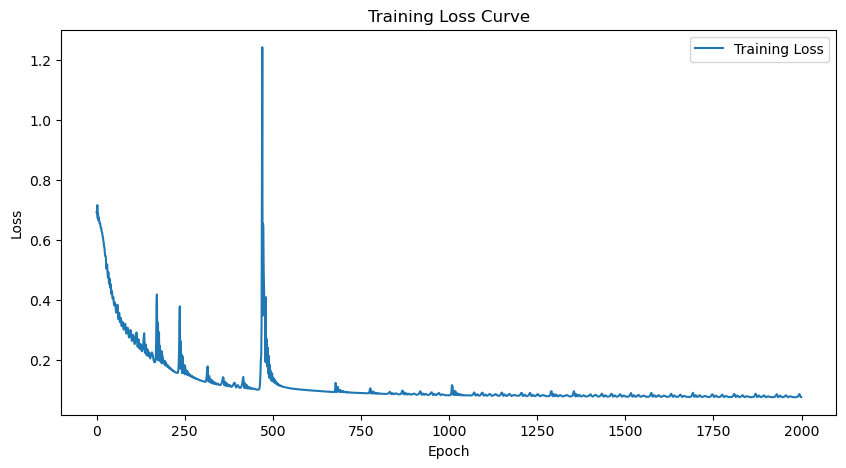

Final Model Accuracy: 83.95%
Final Model F1-score: 0.8544


In [9]:
input_dim = X_train.shape[1]
hidden_dim = 256 
print(f"Training MLP model with input_dim={input_dim} and hidden_dim={hidden_dim}")

custom_mlp, losses, best_accuracy, best_f1 = train_model(X_train, y_train, X_test, y_test, input_dim, hidden_dim)

In [10]:
def save_checkpoint(model, optimizer, epoch, loss, filepath):
    checkpoint = {
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss
    }
    torch.save(checkpoint, filepath)
    print(f"Checkpoint saved to '{filepath}'.")

save_checkpoint(custom_mlp, torch.optim.Adam(custom_mlp.parameters()), len(losses), losses[-1], checkpoint_file)

Checkpoint saved to '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/models/train_input_reference_0_layer.pth'.


In [ ]:
y_pred_final = (torch.sigmoid(torch.tensor(custom_mlp(torch.tensor(X_test, dtype=torch.float32)))) > 0.5).float().numpy()
print(classification_report(y_test, y_pred_final, target_names=["infringement", "non_infringement"]))

                  precision    recall  f1-score   support

    infringement       0.95      0.72      0.82       194
non_infringement       0.77      0.96      0.85       186

        accuracy                           0.84       380
       macro avg       0.86      0.84      0.84       380
    weighted avg       0.86      0.84      0.84       380



/tmp/ipykernel_114262/2137335780.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred_final = (torch.sigmoid(torch.tensor(custom_mlp(torch.tensor(X_test, dtype=torch.float32)))) > 0.5).float().numpy()


: 